# Kaggle Competition Spaceship Titanic

## Datenbeschreibung

https://www.kaggle.com/competitions/spaceship-titanic/overview

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

<b>File and Data Field Descriptions</b>

<b><i>train.csv</i></b> - Personal records for about two-thirds (&#126;8700) of the passengers, to be used as training data.<br>
<i>PassengerId</i> - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.<br>
<i>HomePlanet</i> - The planet the passenger departed from, typically their planet of permanent residence.<br>
<i>CryoSleep</i> - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.<br>
<i>Cabin</i> - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.<br>
<i>Destination</i> - The planet the passenger will be debarking to.<br>
<i>Age</i> - The age of the passenger.<br>
<i>VIP</i> - Whether the passenger has paid for special VIP service during the voyage.<br>
<i>RoomService, FoodCourt, ShoppingMall, Spa, VRDeck</i> - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.<br>
Name</i> - The first and last names of the passenger.<br>
<i>Transported</i> - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.<br><br>
<b><i>test.csv</i></b> - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.<br><br>
<b><i>sample_submission.csv</i></b> - A submission file in the correct format.<br>
<i>PassengerId</i> - Id for each passenger in the test set.<br>
<i>Transported</i> - The target. For each passenger, predict either True or False.

## Bibliotheken importieren

In [1]:
import pandas as pd
import numpy as np
import math

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid', palette='muted')

In [2]:
# import MLs
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV

In [3]:
# import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [4]:
# Datavorbereitung & -transformation
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

## Data einlesen

In [5]:
data = pd.read_csv("train.csv", sep=',', engine='python')
data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

## Datenübersicht & NULL Werte

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
# Den Prozentsatz der leeren Werte für jede Spalte
data.isnull().sum()

d = {
    'Column': data.isnull().sum().index,
    'Num Nulls': data.isnull().sum().values,
    '% Nulls': ((data.isnull().sum().values / data.shape[0]) * 100).round(2)}
nulls_df = pd.DataFrame(data=d)

nulls_df

Column  Num Nulls  % Nulls
0    PassengerId          0     0.00
1     HomePlanet        201     2.31
2      CryoSleep        217     2.50
3          Cabin        199     2.29
4    Destination        182     2.09
5            Age        179     2.06
6            VIP        203     2.34
7    RoomService        181     2.08
8      FoodCourt        183     2.11
9   ShoppingMall        208     2.39
10           Spa        183     2.11
11        VRDeck        188     2.16
12          Name        200     2.30
13   Transported          0     0.00

- Die PassengerId Spalte enthaltet keine leeren Werte .
- Die übrigen Spalten enthalten nicht mehr als 2% Leerwerte. Solche Spalten können gespeichert und leere Werte ersetzt werden, siehe Abschnitt 'Data Vorbereitung'

In [8]:
##  Verteilung der unbekannten Werte in Abhängigkeit vom Wert der Zielvariablen

columns=[]
transported=[]
not_transported=[]

for col in data.columns:
    if data[col].isnull().sum() > 0:
        tmp = data.loc[data[col].isnull(), ['Transported']].groupby('Transported').size()
        columns.append(col)
        transported.append(round(tmp[True] / tmp.values.sum() * 100, 2))
        not_transported.append(round(tmp[False] / tmp.values.sum() * 100, 2))

d = {'Columns' : columns, 'transported %' : transported, 'not_transported %': not_transported }   

null_distrib_df = pd.DataFrame(data=d)

null_distrib_df

Columns  transported %  not_transported %
0     HomePlanet          51.24              48.76
1      CryoSleep          48.85              51.15
2          Cabin          50.25              49.75
3    Destination          50.55              49.45
4            Age          50.28              49.72
5            VIP          51.23              48.77
6    RoomService          45.86              54.14
7      FoodCourt          54.10              45.90
8   ShoppingMall          54.81              45.19
9            Spa          49.73              50.27
10        VRDeck          52.13              47.87
11          Name          50.50              49.50

- Verteilung der leeren Werte in Spalten in Abhängigkeit von der Zielvariablen - gleichmäßig


In [9]:
# nulls in Zeilen
tmp = data.isnull().sum(axis=1)
nulls_in_rows = pd.DataFrame(data = {'row' : tmp.index, 'null_num' : tmp.values})
nulls_in_rows.groupby('null_num', as_index=False).size()

null_num  size
0         0  6606
1         1  1867
2         2   203
3         3    17

- 2087 Zeilen haben Null Werte.
- Nur 17 Zeilen enthalten 3 Null Werte.
- Alle Zeile können beibehalten werden.

In [10]:
# Zeile mit nulls anschauen
data.iloc[data.isnull().sum(axis=1).gt(2).values, :]

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
1203     1284_01       Mars      True   F/247/S            NaN   NaN  False   
2639     2822_02      Earth       NaN   G/450/S    TRAPPIST-1e   5.0    NaN   
2762     2970_01      Earth     False       NaN    TRAPPIST-1e   NaN  False   
3072     3315_01      Earth       NaN   F/627/S    TRAPPIST-1e  15.0  False   
3535     3790_01        NaN      True   G/620/P    TRAPPIST-1e  13.0  False   
3882     4167_01      Earth     False       NaN  PSO J318.5-22   NaN    NaN   
4164     4446_05     Europa       NaN   B/175/S    TRAPPIST-1e  33.0  False   
4548     4840_01        NaN      True   F/915/S    TRAPPIST-1e  36.0  False   
5208     5555_01        NaN     False   G/896/S            NaN  43.0    NaN   
5409     5777_01      Earth       NaN  F/1199/P  PSO J318.5-22  46.0    NaN   
5806     6141_02      Earth     False       NaN            NaN  21.0  False   
6057     6405_02      Earth       NaN       NaN            NaN   2.0  False   
6112     6451_01       Mars     False       NaN            NaN  37.0  False   
6904     7314_01     Europa       NaN   C/237/P            NaN  33.0  False   
7019     7472_01       Mars      True  F/1426/S    TRAPPIST-1e   NaN  False   
7211     7703_02        NaN      True  G/1251/S    TRAPPIST-1e  13.0  False   
7682     8202_03        NaN      True   C/306/S    TRAPPIST-1e   NaN  False   

      RoomService  FoodCourt  ShoppingMall    Spa  VRDeck              Name  \
1203          0.0        NaN           0.0    0.0     0.0         Hal Knité   
2639          0.0        0.0           0.0    0.0     NaN   Salley Harverez   
2762        740.0       82.0           6.0    NaN     1.0     Dwin Adkinson   
3072         10.0        0.0          99.0    NaN  2031.0               NaN   
3535          0.0        NaN           0.0    NaN     0.0  Trick Meyersones   
3882          0.0      440.0           0.0    0.0   334.0  Ninaha Deckerson   
4164          0.0     4017.0           NaN    NaN  2260.0    Phah Chocaters   
4548          0.0        0.0           NaN    0.0     0.0               NaN   
5208          1.0        0.0         213.0    7.0   701.0  Winia Blanglison   
5409        559.0       25.0           NaN   22.0   765.0       Katen River   
5806         28.0        0.0           0.0  662.0     0.0               NaN   
6057          0.0        0.0           0.0    0.0     0.0  Feline Toddleton   
6112        610.0        NaN         410.0  148.0    14.0      Carkes Panad   
6904          0.0        0.0           0.0    NaN     0.0  Aldun Venticable   
7019          0.0        0.0           0.0    0.0     NaN               NaN   
7211          0.0        0.0           NaN    0.0     0.0               NaN   
7682          0.0        0.0           0.0    0.0     NaN  Charga Unkcatted   

      Transported  
1203         True  
2639        False  
2762        False  
3072        False  
3535         True  
3882        False  
4164         True  
4548         True  
5208         True  
5409        False  
5806        False  
6057         True  
6112        False  
6904         True  
7019         True  
7211         True  
7682         True

In [11]:
# den Inhalt der Object Spalten anzeigen 

category_features = data.select_dtypes(include="object").columns

for c in category_features:
    if c != 'name':
        print(f"Column: '{c}'",)
        print(data.loc[:, c].unique())

Column: 'PassengerId'
['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
Column: 'HomePlanet'
['Europa' 'Earth' 'Mars' nan]
Column: 'CryoSleep'
[False True nan]
Column: 'Cabin'
['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Column: 'Destination'
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Column: 'VIP'
[False True nan]
Column: 'Name'
['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' ... 'Fayey Connon'
 'Celeon Hontichre' 'Propsh Hontichre']


## Data Visualisierung

In [12]:
for_visual_df = data.copy()

### Neue Features erzeugen

Gemäß der Beschreibung des ursprünglichen Datensatzes die Informationen in den Spalten: 'Cabin', 'PassengerId', 'Name' in mehrere Spalten aufteilen

    --> Cabin: 'CabinDeck', 'CabinNum', 'CabinSide'

In [13]:
for_visual_df[['CabinDeck', 'CabinNum', 'CabinSide']] = for_visual_df['Cabin'].str.split('/', expand=True)

    --> PassengerId: 'GroupId', 'NumInGroup'

In [14]:
for_visual_df[['GroupId', 'NumInGroup']] = for_visual_df['PassengerId'].str.split('_', expand=True)

In [15]:
# numerische Spalten in den Typ float umwandeln
for_visual_df['CabinNum'] = for_visual_df.loc[:,'CabinNum'].astype(float) 
for_visual_df['GroupId'] = for_visual_df.loc[:,'GroupId'].astype(float)

    --> Name: FirstName, LastName

In [16]:
for_visual_df[['FirstName', 'LastName']] = for_visual_df['Name'].str.split(' ', expand=True)

Auf der Grundlage der vorhandenen Daten weitere neue Spalte erstellen

    --> 'GroupSize' (die Anzahl der Personen in jeder Gruppe)

In [17]:
GroupSize_df = for_visual_df.groupby('GroupId', as_index=False).agg(
                                    GroupSize = ('PassengerId', 'count'))
    

for_visual_df = for_visual_df.merge(GroupSize_df, how='left', left_on='GroupId', right_on='GroupId')
for_visual_df.head(5)

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall  ...               Name  Transported  \
0          0.0        0.0           0.0  ...    Maham Ofracculy        False   
1        109.0        9.0          25.0  ...       Juanna Vines         True   
2         43.0     3576.0           0.0  ...      Altark Susent        False   
3          0.0     1283.0         371.0  ...       Solam Susent        False   
4        303.0       70.0         151.0  ...  Willy Santantines         True   

  CabinDeck  CabinNum CabinSide  GroupId NumInGroup  FirstName     LastName  \
0         B       0.0         P      1.0         01      Maham    Ofracculy   
1         F       0.0         S      2.0         01     Juanna        Vines   
2         A       0.0         S      3.0         01     Altark       Susent   
3         A       0.0         S      3.0         02      Solam       Susent   
4         F       1.0         S      4.0         01      Willy  Santantines   

  GroupSize  
0         1  
1         1  
2         2  
3         2  
4         1  

[5 rows x 22 columns]

    --> 'TotalSpend' (Gesamtbetrag der von den Passagieren an Bord des Schiffes ausgegebenen Gelder)

In [18]:
for_visual_df['TotalSpend'] = for_visual_df.loc[:,
                        ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1, min_count=5)

    --> 'HomePlanet' + 'Destination' = 'Route'

In [19]:
for_visual_df['Route'] = for_visual_df['HomePlanet'] + ' - ' +for_visual_df['Destination']

In [20]:
# die Anzahl der Kabinen in jeder Gruppe
for_visual_df.groupby(['GroupId'],as_index=False).agg(cabins=('CabinNum', lambda x: len(x.unique()))).sort_values('cabins', ascending=False)

GroupId  cabins
1388   2092.0     4.0
5459   8129.0     4.0
1132   1709.0     4.0
5814   8668.0     3.0
2611   3911.0     3.0
...       ...     ...
2155   3217.0     1.0
2153   3215.0     1.0
2152   3213.0     1.0
2151   3212.0     1.0
6216   9280.0     1.0

[6217 rows x 2 columns]

    --> 'IsSinge' (reist die Person allein oder in einer Gruppe oder?)

In [21]:
for_visual_df['IsSingle'] = for_visual_df.loc[:, 'GroupSize'].apply(lambda x: x==1 )

    --> 'NoSpend' (der Passagier hat keine Ausgaben an Bord des Schiffes)

In [22]:
for_visual_df['NoSpend'] = for_visual_df.loc[:, 'TotalSpend'].apply(lambda x: np.nan if math.isnan(x) else x==0)

    --> 'IsChild' (Ist der Passagier minderjährig?)

In [23]:
for_visual_df['IsChild'] = for_visual_df.loc[:, 'Age'].apply(lambda x: np.nan if math.isnan(x) else x < 18) 

    --> 'namesakes_num_in_group' (Anzahl der Namensvettern in der Gruppe)

In [24]:
namesakes_in_group_df = for_visual_df.groupby(['LastName', 'GroupId'], as_index=False).agg(
                namesakes_num_in_group = ('PassengerId', 'count'))

for_visual_df = for_visual_df.merge(
    namesakes_in_group_df, how='left',
    left_on=['LastName', 'GroupId'],
    right_on=['LastName', 'GroupId'])

for_visual_df['namesakes_num_in_group'] = for_visual_df['namesakes_num_in_group'] - 1

In [25]:
# #2. число разных фамилий в группе
# namesakes_in_group_df = for_visual_df.groupby(['GroupId'], as_index=False).agg(
#                 namesakes_num_in_group = ('LastName', lambda x: len(x.unique())))

# for_visual_df = for_visual_df.merge(namesakes_in_group_df,
#                                     how='left',
#                                     left_on=['LastName', 'GroupId'],
#                                     right_on=['LastName', 'GroupId'])

# for_visual_df['namesakes_num_in_group'] = for_visual_df['namesakes_num_in_group'] - 1

In [26]:
# #3. число кабин с однофамильцами
# cabins_with_namesakes_df = namesakes_in_cabin_df.groupby(['LastName'], as_index=False).agg(
#                     cabins_num_with_namesakes = ('CabinNum', 'count'))

# for_visual_df = for_visual_df.merge(cabins_with_namesakes_df, how='left', left_on='LastName', right_on='LastName')
# for_visual_df['cabins_num_with_namesakes'] = for_visual_df['cabins_num_with_namesakes'] - 1

    --> 'NameLength' (die Anzahl der Zeichen im Passagiernamen)

In [27]:
for_visual_df['NameLength'] = for_visual_df.loc[:, 'Name'].str.len()

In [28]:
for_visual_df.head(10)

PassengerId HomePlanet CryoSleep  Cabin    Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P    TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S    TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S    TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S    TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S    TRAPPIST-1e  16.0  False   
5     0005_01      Earth     False  F/0/P  PSO J318.5-22  44.0  False   
6     0006_01      Earth     False  F/2/S    TRAPPIST-1e  26.0  False   
7     0006_02      Earth      True  G/0/S    TRAPPIST-1e  28.0  False   
8     0007_01      Earth     False  F/3/S    TRAPPIST-1e  35.0  False   
9     0008_01     Europa      True  B/1/P    55 Cancri e  14.0  False   

   RoomService  FoodCourt  ShoppingMall  ...  FirstName     LastName  \
0          0.0        0.0           0.0  ...      Maham    Ofracculy   
1        109.0        9.0          25.0  ...     Juanna        Vines   
2         43.0     3576.0           0.0  ...     Altark       Susent   
3          0.0     1283.0         371.0  ...      Solam       Susent   
4        303.0       70.0         151.0  ...      Willy  Santantines   
5          0.0      483.0           0.0  ...     Sandie   Hinetthews   
6         42.0     1539.0           3.0  ...     Billex  Jacostaffey   
7          0.0        0.0           0.0  ...     Candra  Jacostaffey   
8          0.0      785.0          17.0  ...     Andona       Beston   
9          0.0        0.0           0.0  ...    Erraiam       Flatic   

  GroupSize  TotalSpend                  Route  IsSingle NoSpend  IsChild  \
0         1         0.0   Europa - TRAPPIST-1e      True    True    False   
1         1       736.0    Earth - TRAPPIST-1e      True   False    False   
2         2     10383.0   Europa - TRAPPIST-1e     False   False    False   
3         2      5176.0   Europa - TRAPPIST-1e     False   False    False   
4         1      1091.0    Earth - TRAPPIST-1e      True   False     True   
5         1       774.0  Earth - PSO J318.5-22      True   False    False   
6         2      1584.0    Earth - TRAPPIST-1e     False   False    False   
7         2         NaN    Earth - TRAPPIST-1e     False     NaN    False   
8         1      1018.0    Earth - TRAPPIST-1e      True   False    False   
9         3         0.0   Europa - 55 Cancri e     False    True     True   

  namesakes_num_in_group NameLength  
0                    0.0       15.0  
1                    0.0       12.0  
2                    1.0       13.0  
3                    1.0       12.0  
4                    0.0       17.0  
5                    0.0       17.0  
6                    1.0       18.0  
7                    1.0       18.0  
8                    0.0       13.0  
9                    2.0       14.0  

[10 rows x 29 columns]

### Verteilung der Zielvariable

([<matplotlib.patches.Wedge at 0x1bc25bc1f70>,
 [Text(0.012522008688130899, 1.0999287246446539, 'False'),
  Text(-0.012522008688131034, -1.0999287246446539, 'True')],
 [Text(0.006830186557162308, 0.5999611225334475, '49.6%'),
  Text(-0.006830186557162382, -0.5999611225334475, '50.4%')])

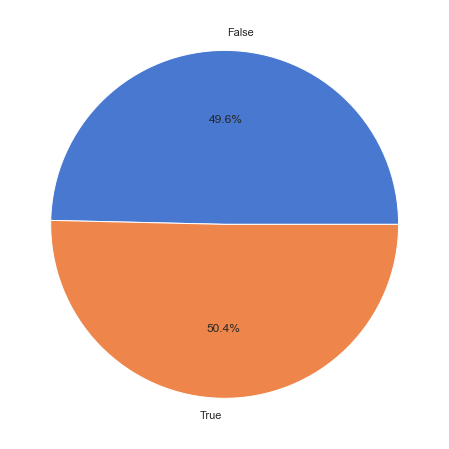

In [29]:
fig, axs = plt.subplots(figsize=(10, 8))
d = for_visual_df.groupby('Transported', as_index=False).size()

axs.pie(d['size'], labels= d['Transported'], autopct='%1.1f%%')

Die Gruppen: Transported und Not Transported sind ungefähr gleich groß. 50.4% und 49.6%

In [30]:
for_visual_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PassengerId             8693 non-null   object 
 1   HomePlanet              8492 non-null   object 
 2   CryoSleep               8476 non-null   object 
 3   Cabin                   8494 non-null   object 
 4   Destination             8511 non-null   object 
 5   Age                     8514 non-null   float64
 6   VIP                     8490 non-null   object 
 7   RoomService             8512 non-null   float64
 8   FoodCourt               8510 non-null   float64
 9   ShoppingMall            8485 non-null   float64
 10  Spa                     8510 non-null   float64
 11  VRDeck                  8505 non-null   float64
 12  Name                    8493 non-null   object 
 13  Transported             8693 non-null   bool   
 14  CabinDeck               8494 non-null   

### Visualisierung von kategorialen Features

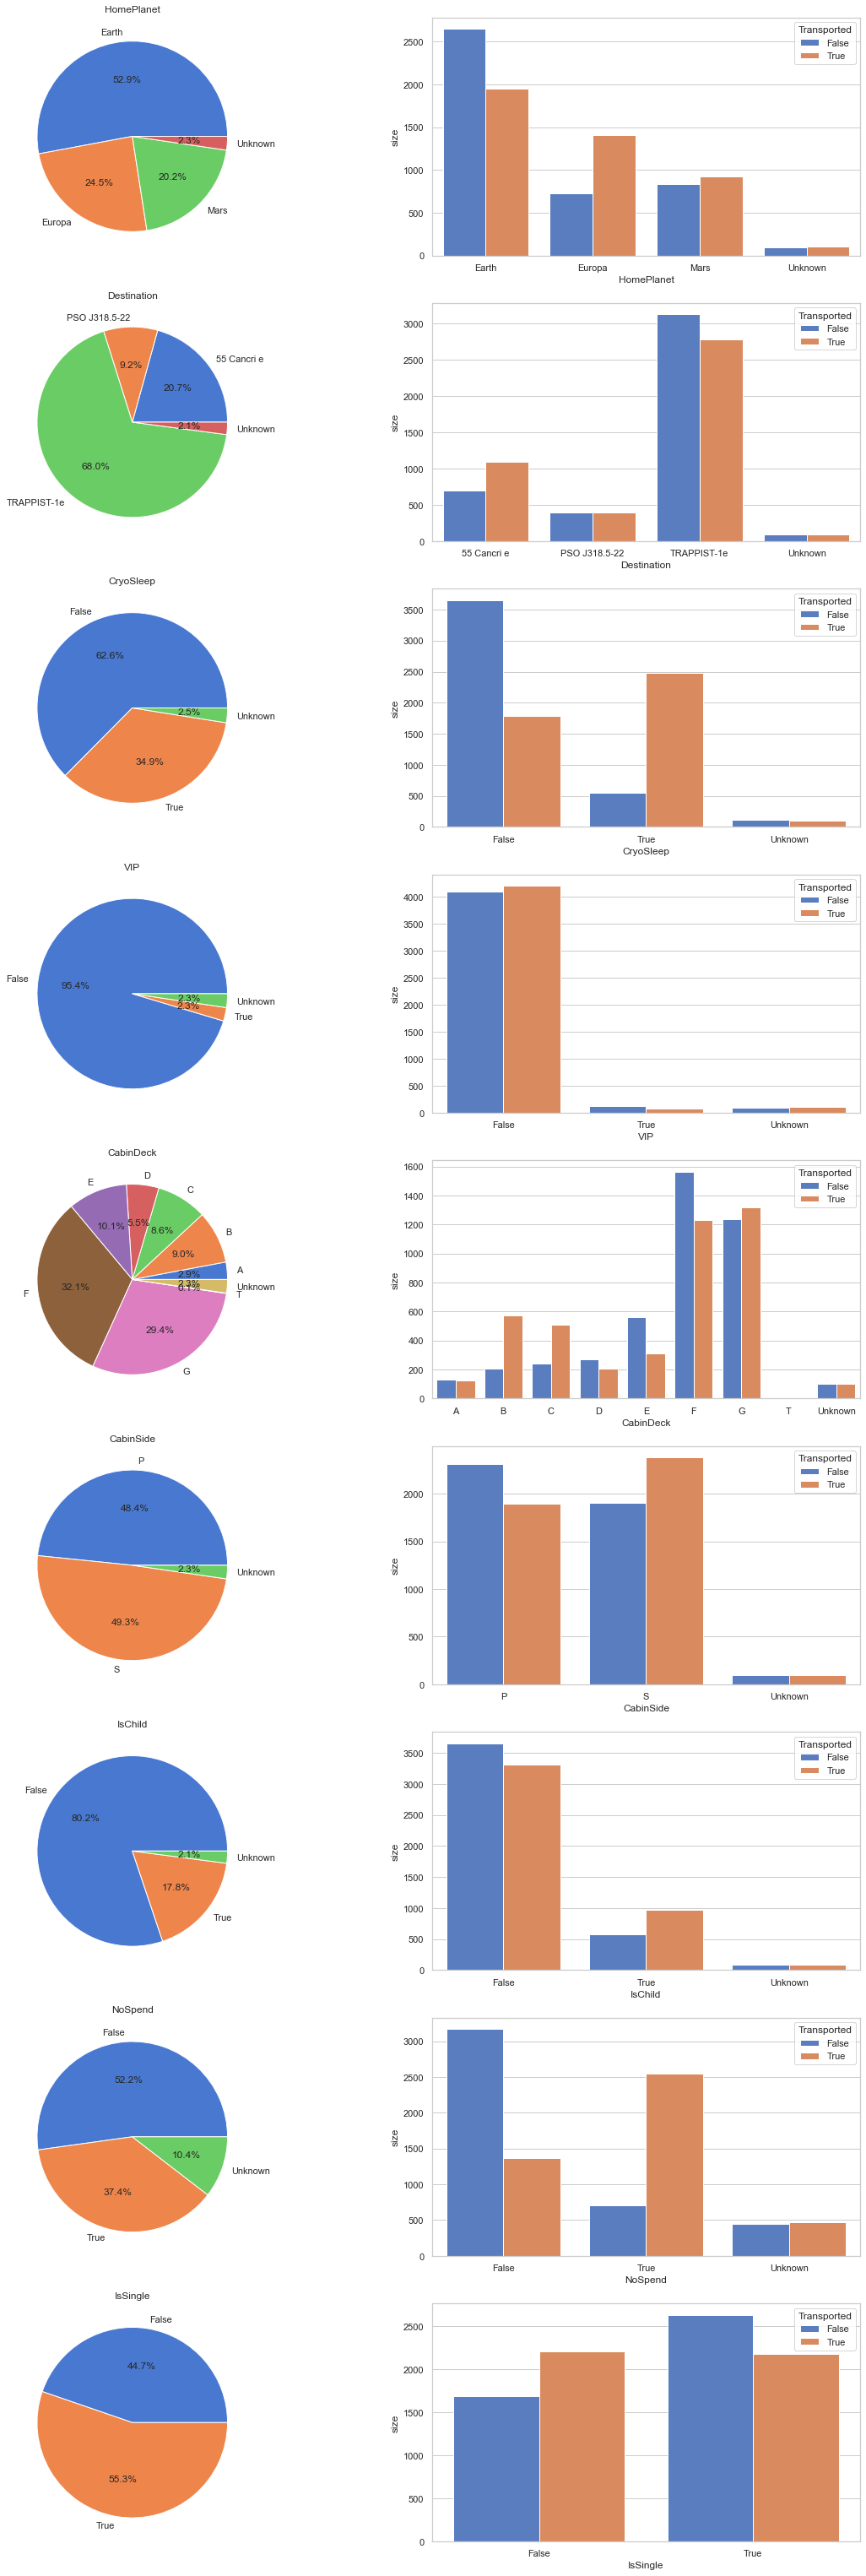

In [31]:
category_features = [
    'HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'CabinDeck', 'CabinSide', 'IsChild', 'NoSpend', 'IsSingle']

fig, axs = plt.subplots(9, 2, figsize=(20, 55))
i = 0
axe = axs.ravel()

for f in category_features: #i, f in enumerate(category_features):
    d1 = for_visual_df.groupby(f, as_index=False, dropna=False).size()
    d1= d1.fillna('Unknown')
    axe[i].pie(d1['size'], labels=d1[f], autopct='%1.1f%%')
    axe[i].set_title(f)
    i+=1
    
    d2 = for_visual_df.groupby([f, 'Transported'], as_index=False, dropna=False).size()
    d2= d2.fillna('Unknown')
    sns.barplot(x=f, y="size",
                hue="Transported",
                data=d2, ax=axe[i])
    i+=1


<b>Erkenntnisse:</b>

--------- <b>Plot 1 'HomePlanet'</b> --------
- Die meisten Passagiere reisen vom Planeten 'Earth'
- Es besteht ein eindeutiger Zusammenhang zwischen der Anzahl der Transported und dem 'HomePlanet'. 
- Die Gruppe der Passagiere, die Transported wurden, für den Planeten 'Earth' ist kleiner, für den 'Europa' wiederum ist die Gruppe der Passagiere, die Transported wurden, größer, für den Mars bleibt das Verhältnis ungefähr gleich.


--------- <b>Plot 2 'Destination'</b> --------


<AxesSubplot:xlabel='size', ylabel='Route'>

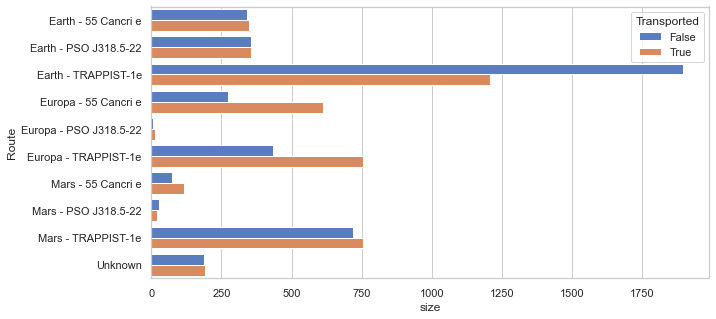

In [32]:
fig, axs = plt.subplots(figsize=(10, 5))

d = for_visual_df.groupby(['Route', 'Transported'], as_index=False, dropna=False).size()
d= d.fillna('Unknown')

sns.barplot(x='size', y="Route",
                hue="Transported",
                data=d)

### Visualisierung von numerischen Features

<AxesSubplot:xlabel='RoomService', ylabel='Count'>

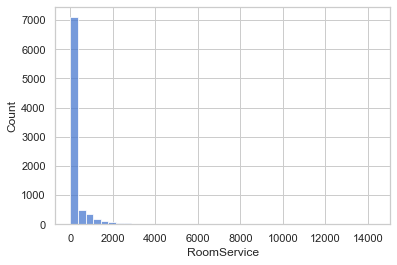

In [33]:
sns.histplot(data=for_visual_df, x='RoomService', bins=40)


In [34]:
num_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend' ]

for f in num_features:
    for_visual_df[f+'_log'] = np.log10(for_visual_df[f] + 1)

In [35]:
for_visual_df.head(5)

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall  ...  NoSpend  IsChild  \
0          0.0        0.0           0.0  ...     True    False   
1        109.0        9.0          25.0  ...    False    False   
2         43.0     3576.0           0.0  ...    False    False   
3          0.0     1283.0         371.0  ...    False    False   
4        303.0       70.0         151.0  ...    False     True   

  namesakes_num_in_group  NameLength RoomService_log  FoodCourt_log  \
0                    0.0        15.0        0.000000       0.000000   
1                    0.0        12.0        2.041393       1.000000   
2                    1.0        13.0        1.643453       3.553519   
3                    1.0        12.0        0.000000       3.108565   
4                    0.0        17.0        2.482874       1.851258   

  ShoppingMall_log   Spa_log VRDeck_log TotalSpend_log  
0         0.000000  0.000000   0.000000       0.000000  
1         1.414973  2.740363   1.653213       2.867467  
2         0.000000  3.827111   1.698970       4.016365  
3         2.570543  3.522444   2.287802       3.714078  
4         2.181844  2.752816   0.477121       3.038223  

[5 rows x 35 columns]

<AxesSubplot:xlabel='Age', ylabel='Count'>

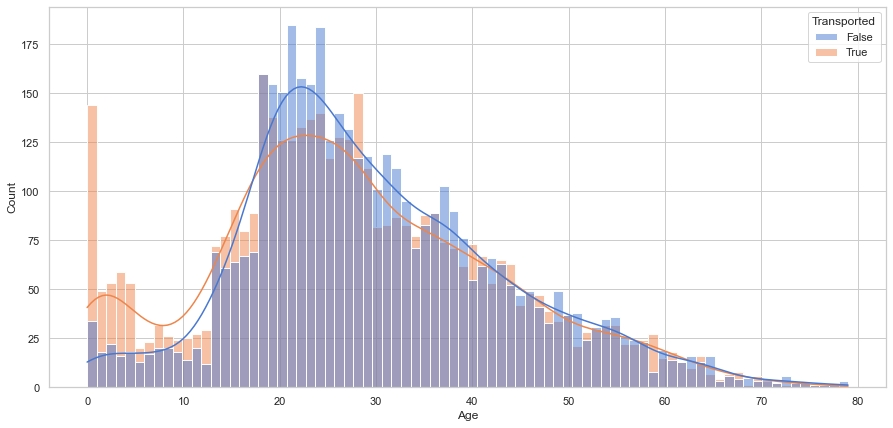

In [36]:
fig, axs = plt.subplots(figsize=(15, 7))
sns.histplot(data=for_visual_df, x='Age', bins=80, hue="Transported", kde=True)


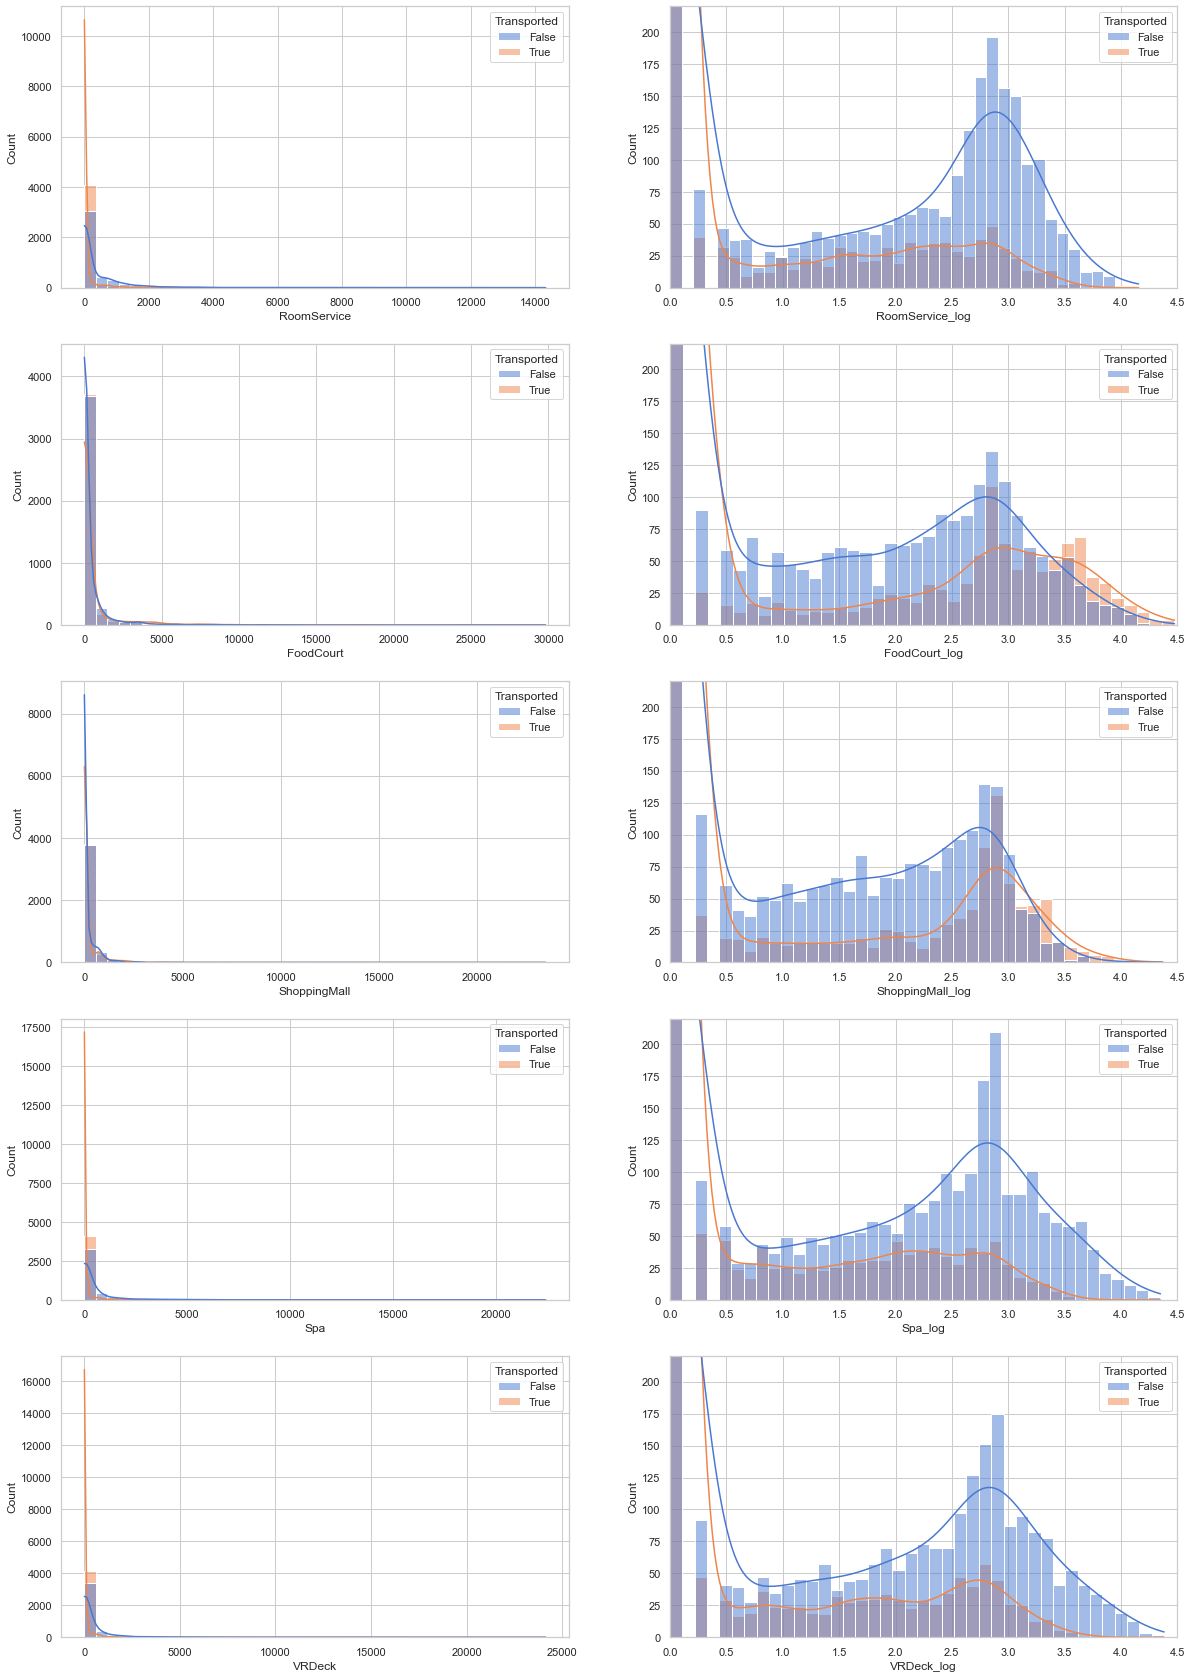

In [37]:

num_features = ['RoomService', 'RoomService_log',
                'FoodCourt', 'FoodCourt_log',
                'ShoppingMall','ShoppingMall_log',
                'Spa', 'Spa_log',
                'VRDeck', 'VRDeck_log']

fig, axs = plt.subplots(5, 2, figsize=(20, 30))
axe = axs.ravel()

for i, f in enumerate(num_features):
    sns.histplot(data=for_visual_df, x=f, ax=axe[i], bins=40, hue="Transported", kde=True)
    if i%2:
#        axe[i].set(xscale="log")
        axe[i].set_xlim(0,4.5)
        axe[i].set_ylim(0,220)

<AxesSubplot:xlabel='TotalSpend_log', ylabel='Count'>

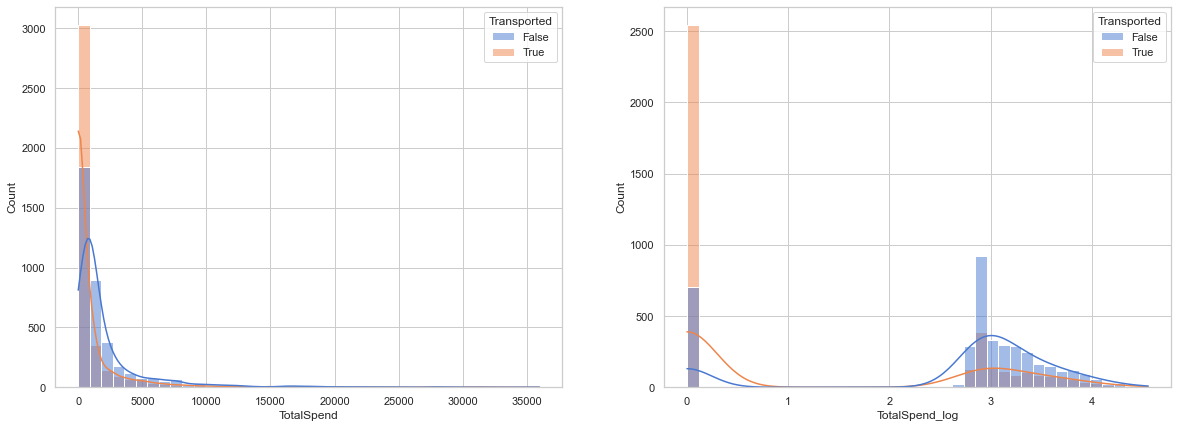

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axe = axs.ravel()

sns.histplot(data=for_visual_df, x='TotalSpend', ax=axe[0], bins=40, hue="Transported", kde=True)
sns.histplot(data=for_visual_df, x='TotalSpend_log', ax=axe[1], bins=40, hue="Transported", kde=True)

<AxesSubplot:xlabel='GroupSize', ylabel='size'>

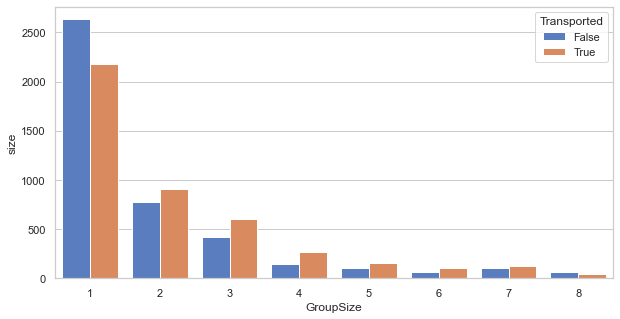

In [39]:
fig, axs = plt.subplots(figsize=(10, 5))
d = for_visual_df.groupby(['GroupSize', 'Transported'], as_index=False, dropna=False).size()

sns.barplot(x='GroupSize', y="size",
                hue="Transported",
                data=d)

<AxesSubplot:xlabel='HomePlanet', ylabel='Destination'>

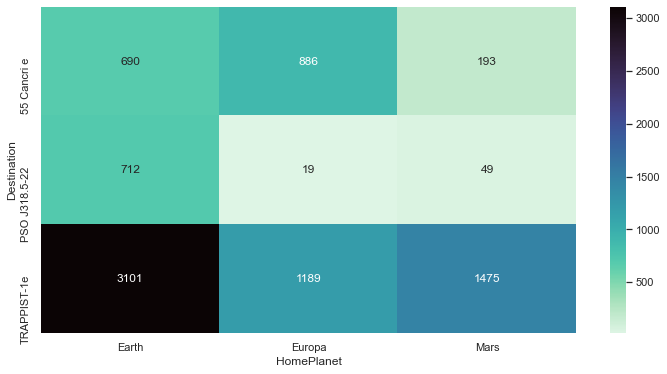

In [40]:
d=for_visual_df.groupby(['Destination', 'HomePlanet']).size().unstack().fillna(0)

fig, axs = plt.subplots(figsize=(12, 6))
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r')

<AxesSubplot:xlabel='CabinDeck', ylabel='HomePlanet'>

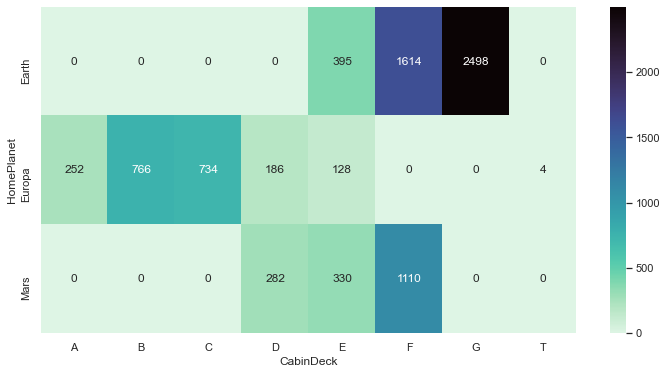

In [41]:
d=for_visual_df.groupby(['HomePlanet', 'CabinDeck']).size().unstack().fillna(0)

fig, axs = plt.subplots(figsize=(12, 6))
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r')

<AxesSubplot:xlabel='CabinDeck', ylabel='Destination'>

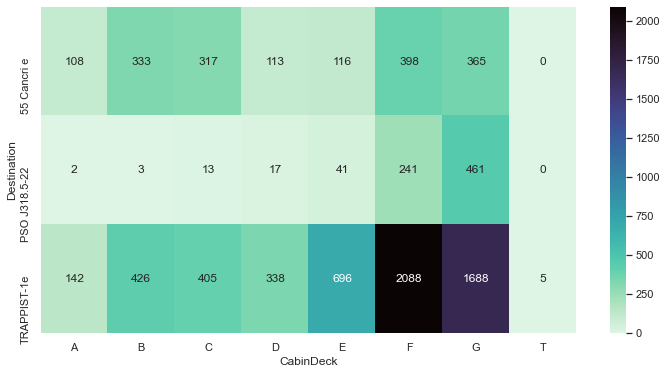

In [42]:
d=for_visual_df.groupby(['Destination', 'CabinDeck']).size().unstack().fillna(0)

fig, axs = plt.subplots(figsize=(12, 6))
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r')

<AxesSubplot:xlabel='CabinDeck', ylabel='Route'>

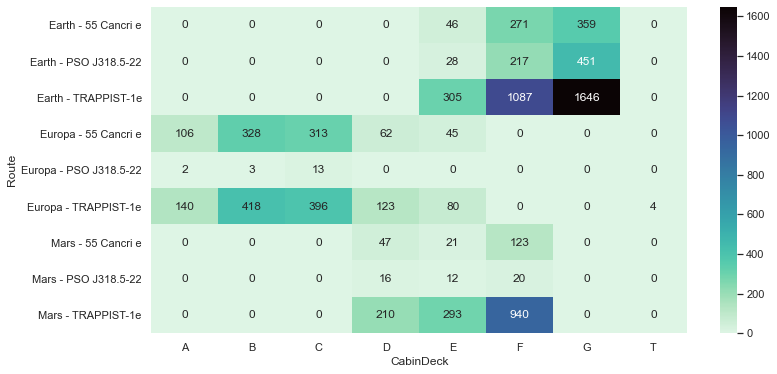

In [43]:
d=for_visual_df.groupby(['Route', 'CabinDeck']).size().unstack().fillna(0)

fig, axs = plt.subplots(figsize=(12, 6))
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r')

In [44]:
for_visual_df.loc[:, ['GroupId', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
                                   'Spa', 'VRDeck', 'CabinNum', 'GroupSize', 'TotalSpend']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GroupId       8693 non-null   float64
 1   Age           8514 non-null   float64
 2   RoomService   8512 non-null   float64
 3   FoodCourt     8510 non-null   float64
 4   ShoppingMall  8485 non-null   float64
 5   Spa           8510 non-null   float64
 6   VRDeck        8505 non-null   float64
 7   CabinNum      8494 non-null   float64
 8   GroupSize     8693 non-null   int64  
 9   TotalSpend    7785 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 747.1 KB


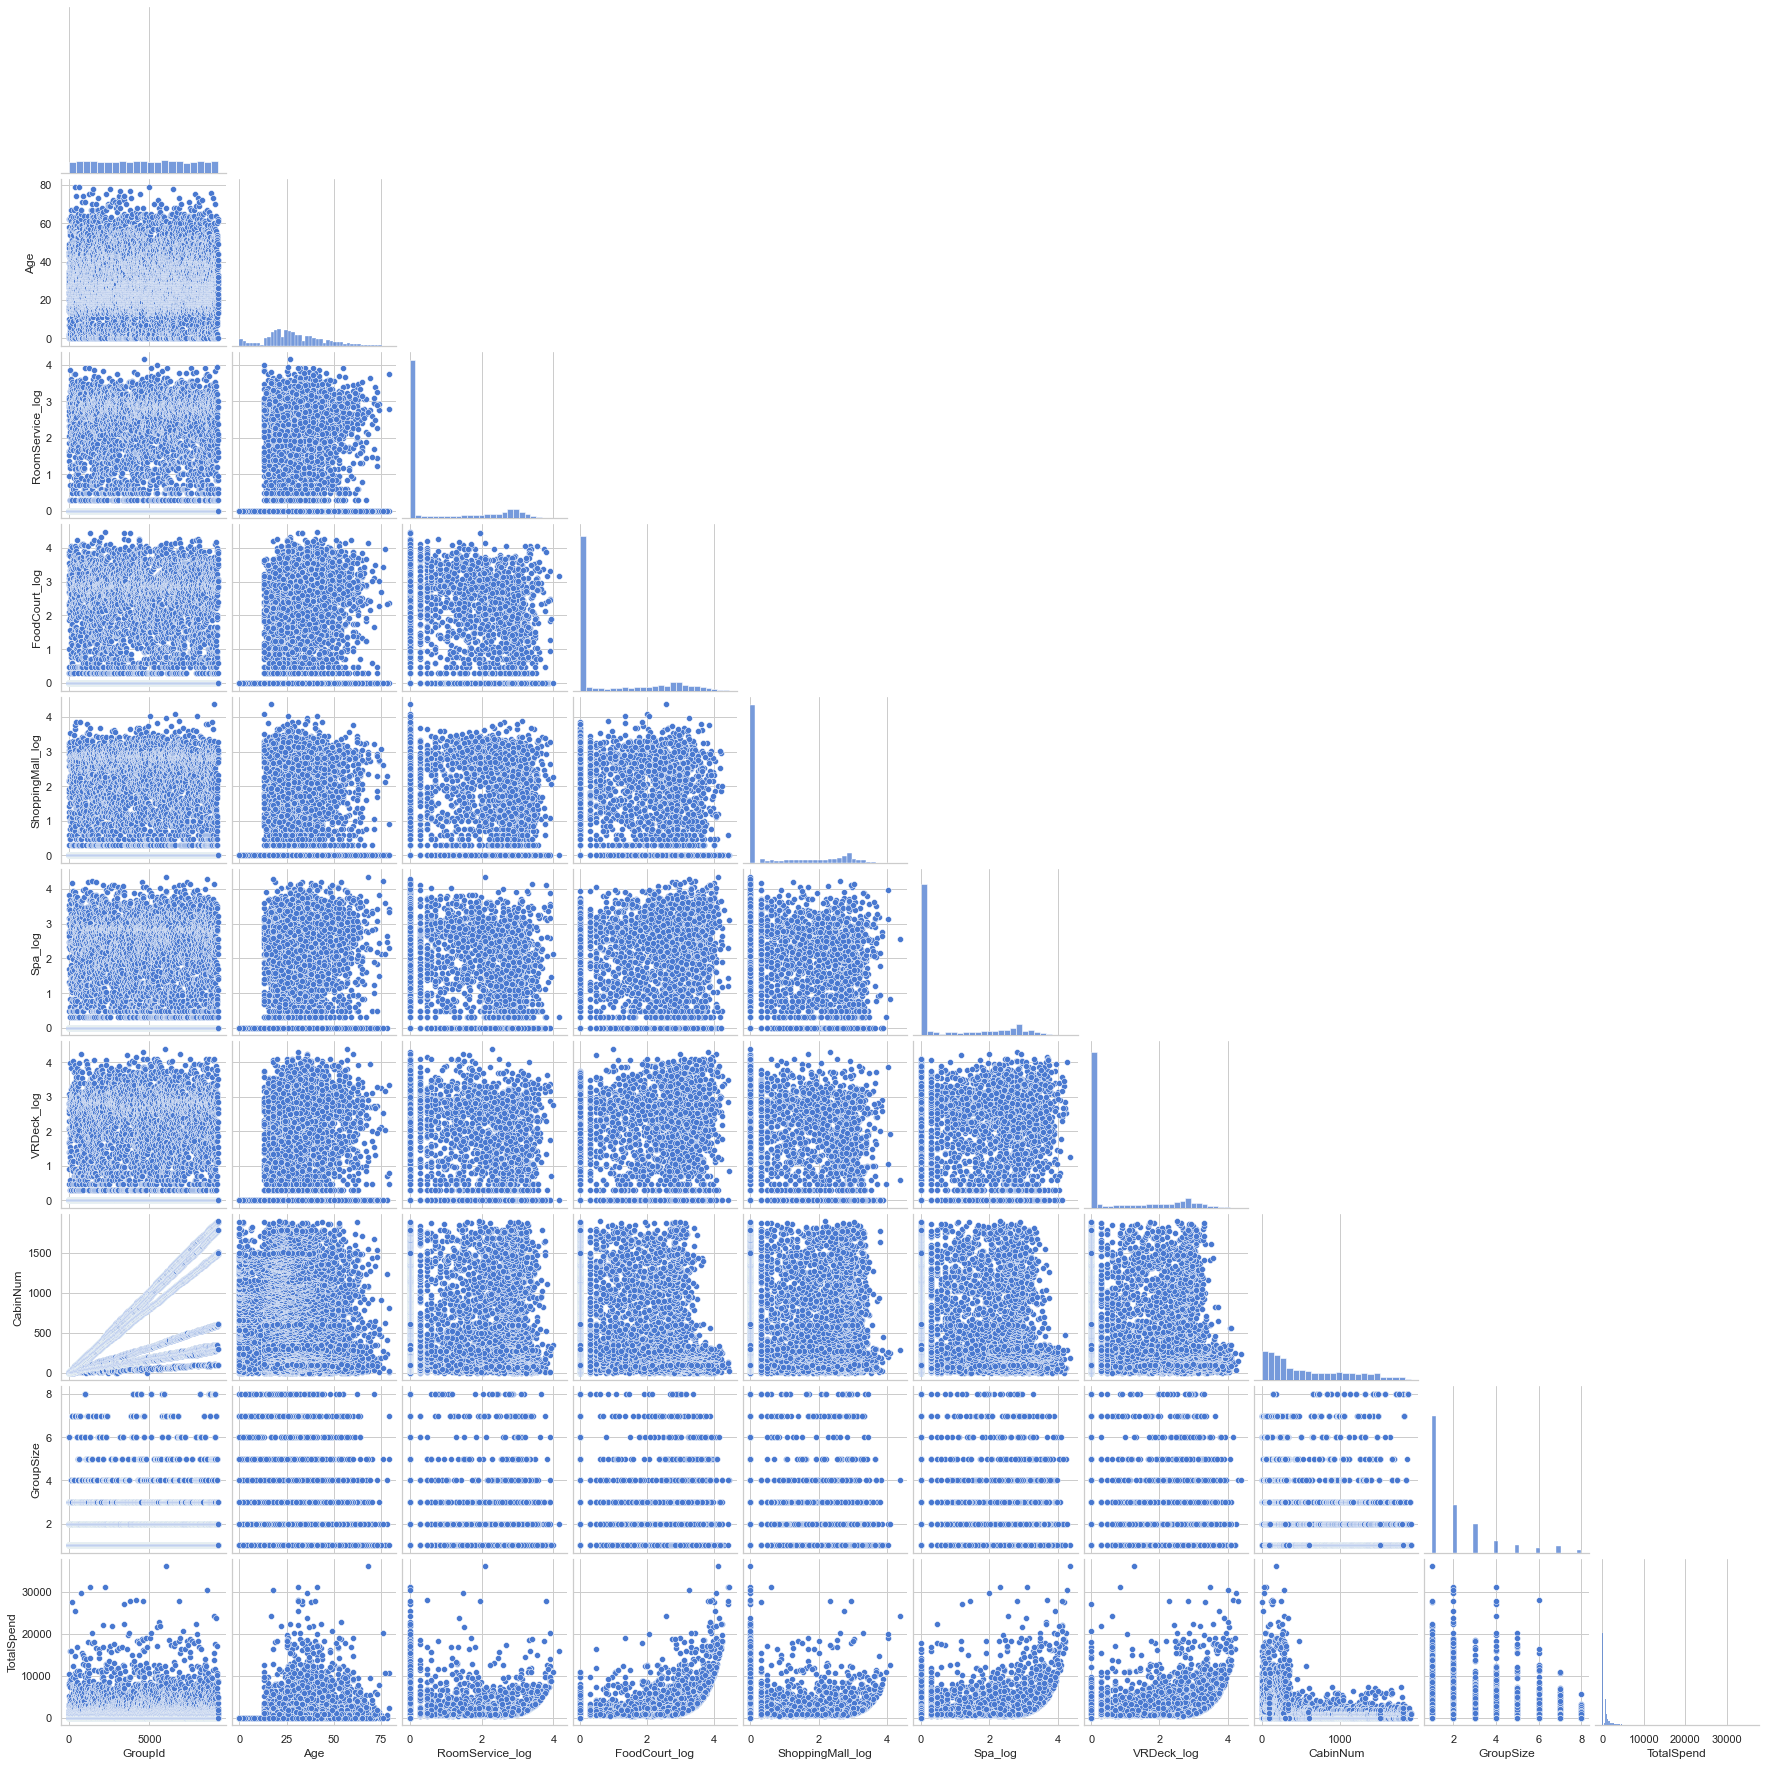

In [45]:
sns.pairplot(for_visual_df.loc[:, ['GroupId', 'Age', 'RoomService_log', 'FoodCourt_log', 'ShoppingMall_log',
                                   'Spa_log', 'VRDeck_log', 'CabinNum', 'GroupSize', 'TotalSpend']],
             corner=True)

<AxesSubplot:xlabel='CabinNum', ylabel='GroupId'>

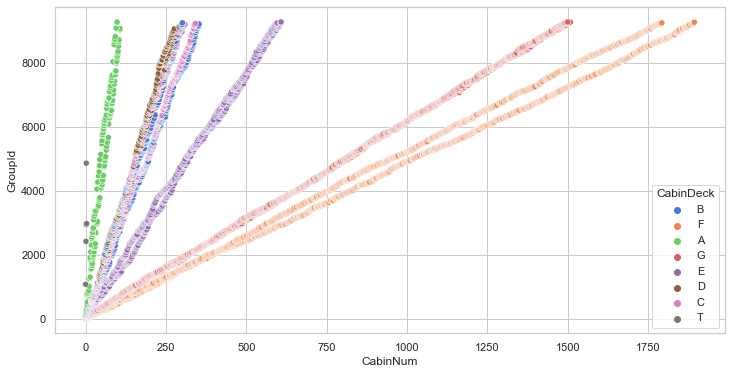

In [46]:
fig, axs = plt.subplots(figsize=(12, 6))

sns.scatterplot(data=for_visual_df, x='CabinNum', y='GroupId', hue='CabinDeck', ax=axs)


<AxesSubplot:xlabel='Age', ylabel='TotalSpend'>

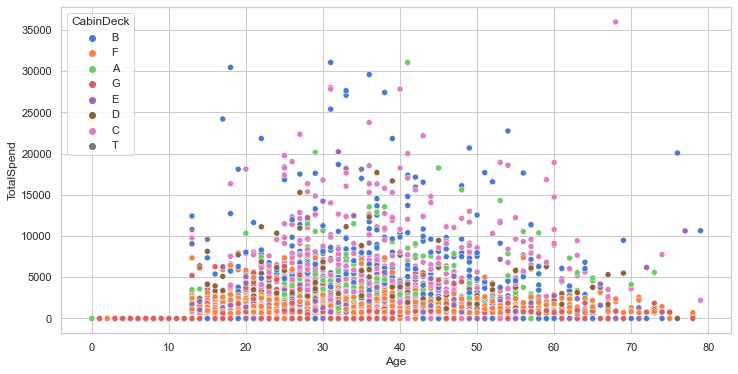

In [47]:
fig, axs = plt.subplots(figsize=(12, 6))

sns.scatterplot(data=for_visual_df,x="Age", y="TotalSpend", hue='CabinDeck',ax=axs)

In [48]:
for_visual_df.loc[for_visual_df['Age'] < 13, ['CabinDeck']].value_counts()

CabinDeck
G            548
F            173
E             23
C             16
B             15
A             12
D              2
dtype: int64

<AxesSubplot:xlabel='NoSpend', ylabel='CryoSleep'>

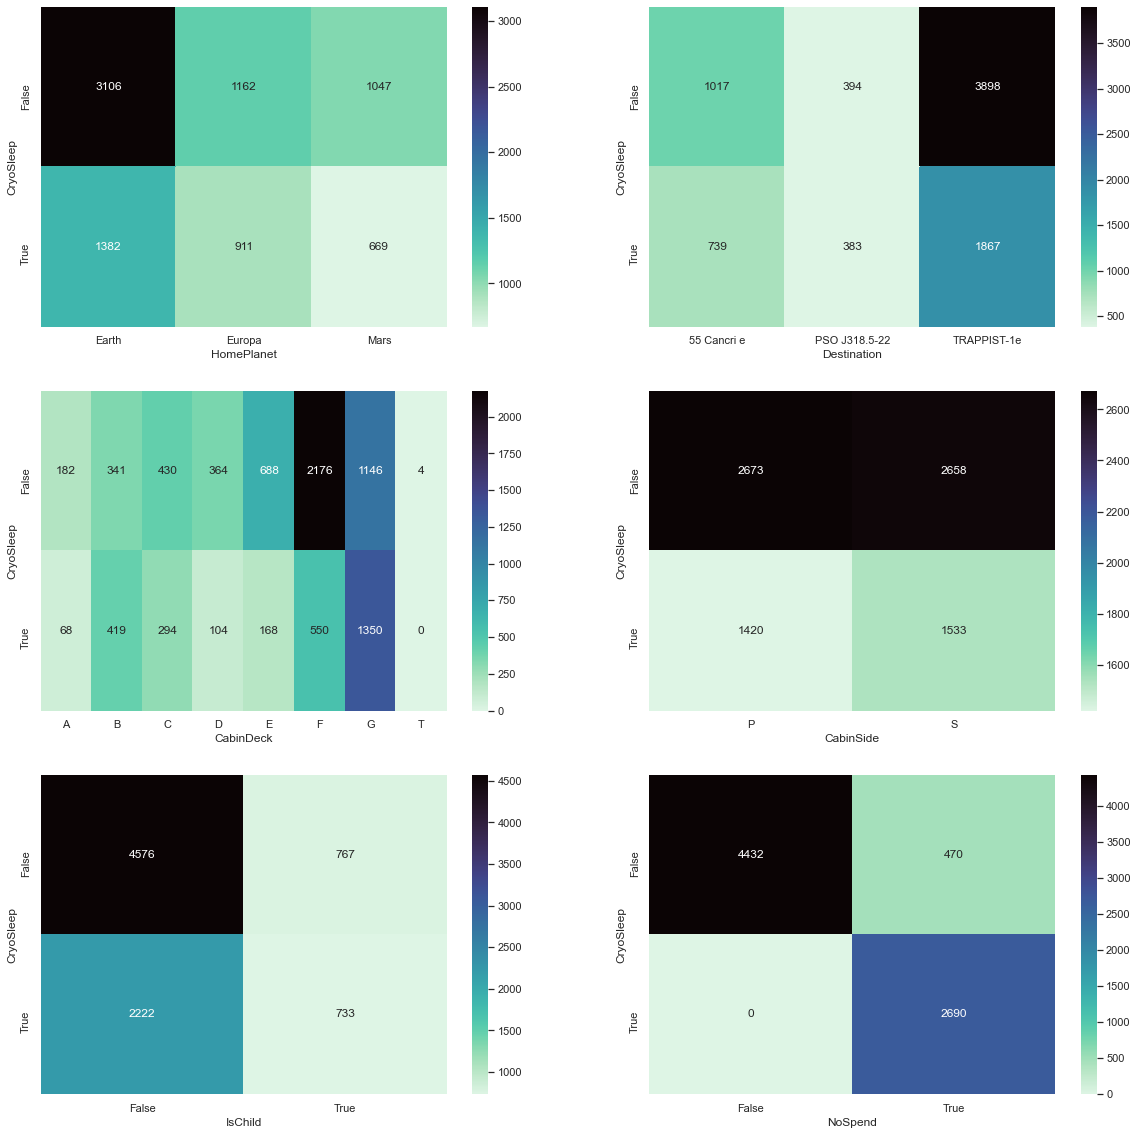

In [49]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs = axs.ravel()
d=for_visual_df.groupby(['CryoSleep', 'HomePlanet']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[0])

d=for_visual_df.groupby(['CryoSleep', 'Destination']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[1])

d=for_visual_df.groupby(['CryoSleep', 'CabinDeck']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[2])

d=for_visual_df.groupby(['CryoSleep', 'CabinSide']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[3])

d=for_visual_df.groupby(['CryoSleep', 'IsChild']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[4])

d=for_visual_df.groupby(['CryoSleep', 'NoSpend']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[5])

# d=for_visual_df.loc[for_visual_df['IsChild']==False, :].groupby(['CryoSleep', 'NoSpend']).size().unstack().fillna(0)
# sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[6])


In [50]:
for_visual_df.groupby(['CryoSleep']).agg(
    max_spend=('TotalSpend', 'max'),
    min_spend=('TotalSpend', 'min'),
    count=('PassengerId', 'count'),
    min_age=('Age', 'min'),
    max_age=('Age', 'max')
)

max_spend  min_spend  count  min_age  max_age
CryoSleep                                               
False        35987.0        0.0   5439      0.0     79.0
True             0.0        0.0   3037      0.0     78.0

<AxesSubplot:xlabel='CabinNum', ylabel='TotalSpendProCabin'>

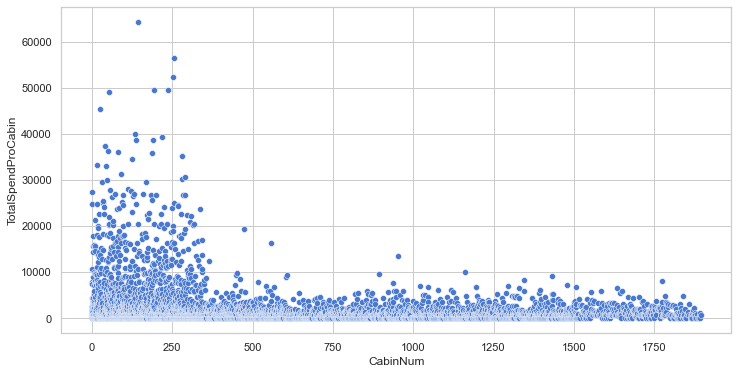

In [51]:
d= for_visual_df.groupby(['CabinNum', 'CabinDeck'], as_index=False).agg(TotalSpendProCabin = ('TotalSpend', 'sum'))

fig, axs = plt.subplots(figsize=(12, 6))

sns.scatterplot(data=d, x='CabinNum', y='TotalSpendProCabin', ax=axs)

<AxesSubplot:xlabel='CabinDeck', ylabel='VIP'>

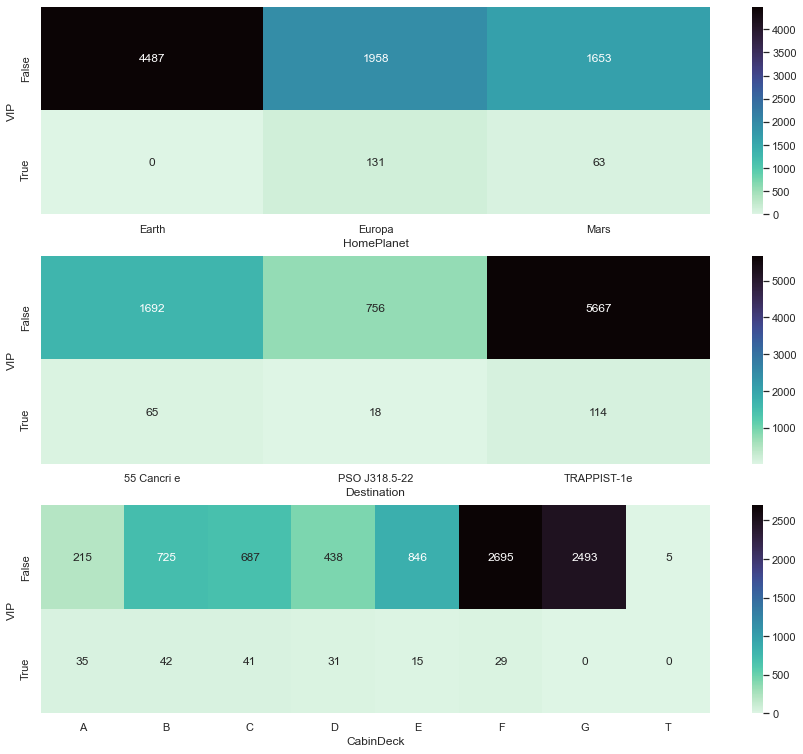

In [52]:
fig, axs = plt.subplots(3, 1, figsize=(15, 13))

d=for_visual_df.groupby(['VIP', 'HomePlanet']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[0])

d=for_visual_df.groupby(['VIP', 'Destination']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[1])

d=for_visual_df.groupby(['VIP', 'CabinDeck']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[2])

    -- Es gibt keine VIP-Passagiere auf Deck G, alle Passagiere auf Deck G sind vom Planeten Erde

In [53]:
for_visual_df.loc[(for_visual_df['VIP'].notnull()) & (for_visual_df['VIP']) & (for_visual_df['HomePlanet'].isnull()), :]

PassengerId HomePlanet CryoSleep     Cabin  Destination   Age   VIP  \
291      0321_01        NaN     False    F/61/S  TRAPPIST-1e  59.0  True   
365      0402_01        NaN      True    D/15/S  55 Cancri e  32.0  True   
405      0444_02        NaN     False    F/99/P  TRAPPIST-1e  26.0  True   
7042     7500_01        NaN     False  F/1432/S  TRAPPIST-1e  54.0  True   
7786     8314_02        NaN     False   D/245/S  55 Cancri e  29.0  True   

      RoomService  FoodCourt  ShoppingMall  ...  NoSpend  IsChild  \
291        1018.0        0.0         209.0  ...    False    False   
365           0.0        0.0           0.0  ...     True    False   
405        1869.0        0.0         136.0  ...    False    False   
7042       1770.0        7.0         228.0  ...    False    False   
7786          0.0     2949.0           0.0  ...    False    False   

     namesakes_num_in_group  NameLength RoomService_log  FoodCourt_log  \
291                     0.0        12.0        3.008174       0.000000   
365                     0.0        12.0        0.000000       0.000000   
405                     1.0        11.0        3.271842       0.000000   
7042                    0.0        11.0        3.248219       0.903090   
7786                    1.0        17.0        0.000000       3.469822   

     ShoppingMall_log   Spa_log VRDeck_log TotalSpend_log  
291          2.322219  0.000000   0.000000       3.089198  
365          0.000000  0.000000   0.000000       0.000000  
405          2.136721  0.000000   0.000000       3.302331  
7042         2.359835  0.000000   0.000000       3.302331  
7786         0.000000  0.477121   2.816241       3.557026  

[5 rows x 35 columns]

<AxesSubplot:xlabel='VIP', ylabel='CryoSleep'>

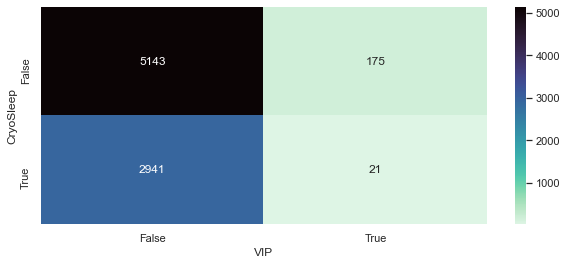

In [54]:
fig, axs = plt.subplots(figsize=(10, 4))

d=for_visual_df.groupby(['CryoSleep', 'VIP']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs)

In [55]:
# d = for_visual_df.groupby('GroupId', as_index=False).agg(
#     sum_cryosleep=('CryoSleep', 'sum'),
#     count = ('PassengerId','size'))
# d.sort_values('sum_cryosleep', ascending=False).head(5)

In [56]:
for_visual_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'CabinDeck', 'CabinNum', 'CabinSide', 'GroupId',
       'NumInGroup', 'FirstName', 'LastName', 'GroupSize', 'TotalSpend',
       'Route', 'IsSingle', 'NoSpend', 'IsChild', 'namesakes_num_in_group',
       'NameLength', 'RoomService_log', 'FoodCourt_log', 'ShoppingMall_log',
       'Spa_log', 'VRDeck_log', 'TotalSpend_log'],
      dtype='object')

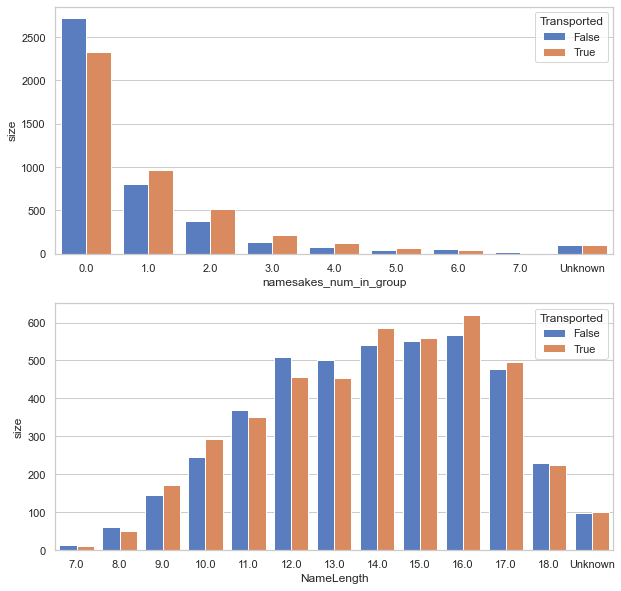

In [57]:
name_features = ['namesakes_num_in_group', 'NameLength', ]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
i = 0
axe = axs.ravel()

for i, f in enumerate(name_features):
    d2 = for_visual_df.groupby([f, 'Transported'], as_index=False, dropna=False).size()
    d2= d2.fillna('Unknown')
    sns.barplot(x=f, y="size",
                hue="Transported",
                data=d2, ax=axe[i])

## Data Vorbereitung

In [58]:
expenses_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", 'VRDeck']

In [59]:
data['Transported'] = data["Transported"].astype(int)

In [60]:
# trenne in trainings und test daten
data_train, data_test = train_test_split(data, train_size=0.8, random_state=7)
# data_train = data

# trenne in X_train/y_train und X_test/y_test 
X_train = data_train.drop(columns="Transported")
y_train = data_train.loc[:, "Transported"]


X_test = data_test.drop(columns="Transported")
y_test = data_test.loc[:, "Transported"]

In [61]:
# Data Transformationen:
# - Name - split: 'FirstName', 'LastName'
#- PassengerId - split: 'GroupId', 'NumInGroup' -- to float

In [62]:
def new_features_create(df):
    df[['FirstName', 'LastName']] = df['Name'].str.split(' ', expand=True)
    df[['GroupId', 'NumInGroup']] = df['PassengerId'].str.split('_', expand=True)
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
    df['IsChild'] = df.loc[:, 'Age'].apply(lambda x: np.nan if math.isnan(x) else x < 18) 
    df['TotalSpend'] = df.loc[:, expenses_cols].sum(axis=1, min_count=5)
    
    df['GroupId'] = df.loc[:,'GroupId'].astype(float) 
    df['NumInGroup'] = df.loc[:,'NumInGroup'].astype(float)
    df['CabinNum'] = df.loc[:,'CabinNum'].astype(float)
    
    GroupSize_df = df.groupby('GroupId', as_index=False).agg(GroupSize = ('PassengerId', 'count'))
    df = df.merge(GroupSize_df, how='left', left_on='GroupId', right_on='GroupId', copy=False)

    df['IsSingle'] = df.loc[:, 'GroupSize'].apply(lambda x: x==1 )
    
    return df

    
X_train = new_features_create(X_train)

In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6954 entries, 0 to 6953
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6788 non-null   object 
 2   CryoSleep     6789 non-null   object 
 3   Cabin         6797 non-null   object 
 4   Destination   6801 non-null   object 
 5   Age           6800 non-null   float64
 6   VIP           6788 non-null   object 
 7   RoomService   6808 non-null   float64
 8   FoodCourt     6806 non-null   float64
 9   ShoppingMall  6796 non-null   float64
 10  Spa           6802 non-null   float64
 11  VRDeck        6803 non-null   float64
 12  Name          6789 non-null   object 
 13  FirstName     6789 non-null   object 
 14  LastName      6789 non-null   object 
 15  GroupId       6954 non-null   float64
 16  NumInGroup    6954 non-null   float64
 17  CabinDeck     6797 non-null   object 
 18  CabinNum      6797 non-null 

In [64]:
X_train.head()

PassengerId HomePlanet CryoSleep     Cabin  Destination   Age    VIP  \
0     6309_02      Earth       NaN  G/1023/S  TRAPPIST-1e   7.0  False   
1     2908_02        NaN     False   F/553/S  TRAPPIST-1e  13.0  False   
2     0548_01      Earth     False    E/36/S  TRAPPIST-1e  24.0  False   
3     8757_01      Earth     False  G/1409/S  TRAPPIST-1e  28.0  False   
4     1644_01      Earth     False   F/327/P  55 Cancri e  14.0  False   

   RoomService  FoodCourt  ShoppingMall  ...    LastName  GroupId NumInGroup  \
0          0.0        0.0           0.0  ...   Rodricker   6309.0        2.0   
1        649.0        2.0           0.0  ...  Berreranks   2908.0        2.0   
2          0.0       86.0         704.0  ...     Webstes    548.0        1.0   
3          1.0     1484.0         210.0  ...    Danielps   8757.0        1.0   
4          0.0        2.0           0.0  ...  Waltonnedy   1644.0        1.0   

  CabinDeck CabinNum  CabinSide  IsChild TotalSpend  GroupSize IsSingle  
0         G   1023.0          S     True        0.0          4    False  
1         F    553.0          S     True      918.0          1     True  
2         E     36.0          S    False      791.0          1     True  
3         G   1409.0          S    False     1700.0          1     True  
4         F    327.0          P     True      796.0          1     True  

[5 rows x 24 columns]

### HomePlanet

In [65]:
for_visual_df.loc[for_visual_df['HomePlanet'].notnull(), :].groupby(['GroupId'], as_index=False).agg(
    HomePlanet_num = ('HomePlanet', lambda x: len(x.unique()))).sort_values('HomePlanet_num', ascending = False)

GroupId  HomePlanet_num
0         1.0               1
4068   6128.0               1
4077   6141.0               1
4076   6139.0               1
4075   6138.0               1
...       ...             ...
2033   3083.0               1
2032   3082.0               1
2031   3081.0               1
2030   3080.0               1
6106   9280.0               1

[6107 rows x 2 columns]

    --> Menschen aus derselben Gruppe fliegen immer vom selben 'HomePlanet'

In [66]:
for_visual_df.loc[
            for_visual_df['HomePlanet'].notnull(), :].groupby(['LastName'], as_index=False).agg(
                                num_planets=('HomePlanet', lambda x: len(x.unique()))).sort_values('num_planets', ascending = False)

LastName  num_planets
0         Acobson            1
1475      Parrett            1
1469        Panie            1
1470      Panspic            1
1471      Parbage            1
...           ...          ...
731       Flynner            1
730   Flyncharlan            1
729   Floydendley            1
728    Flowensley            1
2208   Youngrayes            1

[2209 rows x 2 columns]

    --> Passagiere mit demselben 'LatName' fliegen von demselben Planeten.

In [67]:
def HomePlanet_update(df, source_df):
    print('------ HomePlanet_update ------------')
        
    # Menschen aus derselben Gruppe fliegen immer vom selben 'HomePlanet'
    planet_for_group_df = source_df.loc[source_df['HomePlanet'].notnull(), :].groupby(['GroupId'], as_index=False).agg(
                num_planets=('HomePlanet', lambda x: len(x.unique())),
                not_null_planet = ('HomePlanet', lambda x: x.unique()[0]))
    
    start_nulls_num = df.loc[df['HomePlanet'].isnull(), :].shape[0]
 
    print('HomePlanet NULLs:', start_nulls_num)
    
    
    df['HomePlanet'] = df.apply(
    lambda x: (planet_for_group_df.loc[planet_for_group_df['GroupId'] == x.GroupId, 'not_null_planet'].iloc[0] if planet_for_group_df.loc[planet_for_group_df['GroupId'] == x.GroupId, 'not_null_planet'].shape[0] > 0 else np.nan)
    if x.HomePlanet is np.nan else x.HomePlanet , axis=1)


    print('1. (after replacement through the GroupId) HomePlanet NULLs:', df.loc[df['HomePlanet'].isnull(), :].shape[0])
    
    #----------------------------------------------------------------------
    # wenn Deck A, B, C; T, 'Europa'. Wenn G, dann 'Earth'
    df.loc[(df['HomePlanet'].isnull()) & (df['CabinDeck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'
    df.loc[(df['HomePlanet'].isnull()) & (df['CabinDeck'].isin(['G'])), 'HomePlanet']='Earth'
    
    print('2. (after replacement through the Deck) HomePlanet NULLs:', df.loc[df['HomePlanet'].isnull(), :].shape[0])
    
    # ---------------------------------------------------------------------
    # Passagiere mit demselben 'LatName' fliegen von demselben Planeten
    planet_for_lastname_df = source_df.loc[
            source_df['HomePlanet'].notnull(), :].groupby(['LastName'], as_index=False).agg(
                                num_planets=('HomePlanet', lambda x: len(x.unique())),
                                not_null_planet = ('HomePlanet', lambda x: x.unique()[0]))
    
    df['HomePlanet'] = df.apply(
    lambda x: (planet_for_lastname_df.loc[planet_for_lastname_df['LastName'] == x.LastName, 'not_null_planet'].iloc[0] if planet_for_lastname_df.loc[planet_for_lastname_df['LastName'] == x.LastName, 'not_null_planet'].shape[0] > 0 else np.nan)
    if x.HomePlanet is np.nan else x.HomePlanet , axis=1)
    
    print('3. (after replacement through the LastName) HomePlanet NULLs:', df.loc[df['HomePlanet'].isnull(), :].shape[0])

    #----------------------------------------------------------------------
    df.loc[(df['HomePlanet'].isnull()) & (df['Destination'].isin(['TRAPPIST-1e', 'PSO J318.5-22'])) & (df['CabinDeck'] == 'D'), 'HomePlanet']='Mars'   
    df.loc[(df['HomePlanet'].isnull()) & ~(df['CabinDeck'] == 'D'), 'HomePlanet']='Earth'
    df.loc[(df['HomePlanet'].isnull()) & (df['Destination'] == '55 Cancri e') & (df['CabinDeck'] == 'D'), 'HomePlanet']='Europa'
    
    print('4. (after replacement through the Destination):', df.loc[df['HomePlanet'].isnull(), :].shape[0])
    #------------------------------------------------------------------------
    # für alle verbleibenden leeren Werte durch 'Earth' ersetzen
    df.fillna(value= {'HomePlanet': 'Earth'}, inplace=True)
    
    print('5. (after replacement by the most common value) HomePlanet NULLs:', df.loc[df['HomePlanet'].isnull(), :].shape[0])

    return df
X_train = HomePlanet_update(X_train, for_visual_df)

------ HomePlanet_update ------------
HomePlanet NULLs: 166
1. (after replacement through the GroupId) HomePlanet NULLs: 94
2. (after replacement through the Deck) HomePlanet NULLs: 54
3. (after replacement through the LastName) HomePlanet NULLs: 7
4. (after replacement through the Destination): 0
5. (after replacement by the most common value) HomePlanet NULLs: 0


### Destination

In [68]:
for_visual_df.loc[
            for_visual_df['Destination'].notnull(), :].groupby(['LastName'], as_index=False).agg(
                                num_planets=('Destination', lambda x: len(x.unique())),
                                not_null_planet = ('Destination', lambda x: x.unique()[0])).sort_values('num_planets', ascending=False)

LastName  num_planets not_null_planet
1858      Slable            3   PSO J318.5-22
2099   Villenson            3   PSO J318.5-22
610    Dotsondez            3     55 Cancri e
2102   Vinozarks            3     TRAPPIST-1e
2103     Vinston            3   PSO J318.5-22
...          ...          ...             ...
1018     Howence            1   PSO J318.5-22
1017    Howayery            1     TRAPPIST-1e
1015       Hotty            1     TRAPPIST-1e
1012      Horthy            1     TRAPPIST-1e
2208  Youngrayes            1     TRAPPIST-1e

[2209 rows x 3 columns]

In [69]:
for_visual_df.loc[for_visual_df['Destination'].notnull(), :].groupby(['GroupId'], as_index=False).agg(
    num_planets=('Destination', lambda x: len(x.unique())),
    not_null_planet = ('Destination', lambda x: x.unique()[0])).sort_values('num_planets', ascending=False)

GroupId  num_planets not_null_planet
4426   6672.0            3     TRAPPIST-1e
885    1350.0            3     55 Cancri e
5899   8956.0            3     TRAPPIST-1e
1916   2892.0            3   PSO J318.5-22
5860   8886.0            3     55 Cancri e
...       ...          ...             ...
2477   3757.0            1     TRAPPIST-1e
2476   3756.0            1     TRAPPIST-1e
420     631.0            1     TRAPPIST-1e
2474   3754.0            1     TRAPPIST-1e
0         1.0            1     TRAPPIST-1e

[6114 rows x 3 columns]

    --> Eins-zu-eins-Abhängigkeit zwischen Gruppennummer oder Nachname und Zielort nicht gefunden, leere Werte durch den häufigsten Zielort ersetzen

In [70]:
def Destination_update(df):
    print('------ Destination_update ------------')
    start_nulls_num = df.loc[df['Destination'].isnull(), :].shape[0]
 
    print('Destination NULLs:', start_nulls_num)
    
    df.fillna(value= {'Destination': 'TRAPPIST-1e'}, inplace=True)
    
    print('(after replacement by the most common value) Destination NULLs:', df.loc[df['Destination'].isnull(), :].shape[0])
    
    return df
    
X_train= Destination_update(X_train)
    

------ Destination_update ------------
Destination NULLs: 153
(after replacement by the most common value) Destination NULLs: 0


### LastName

In [71]:
num_unique_last_names_in_group = for_visual_df[for_visual_df['GroupSize'] > 1].groupby(['GroupId'], as_index=False).agg(
                lastname_num_in_group = ('LastName', lambda x: len(x.value_counts()))).groupby('lastname_num_in_group').size().sort_values()
num_unique_last_names_in_group

lastname_num_in_group
4       1
3      23
2     225
1    1163
dtype: int64

Text(0.5, 1.0, 'Number of unique surnames by group')

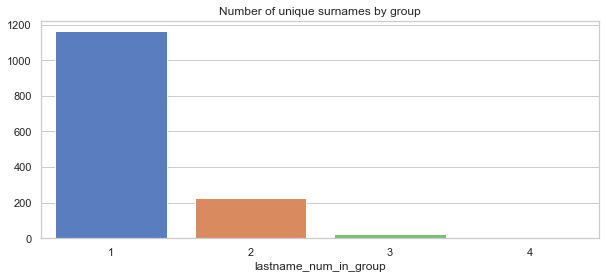

In [72]:
# Countplot of unique values
plt.figure(figsize=(10,4))
sns.barplot(x=num_unique_last_names_in_group.index, y=num_unique_last_names_in_group.values)
plt.title('Number of unique surnames by group')

In [73]:
for_visual_df.loc[for_visual_df['LastName'].notnull(), ['GroupId', 'LastName']].groupby(['GroupId'], as_index=False).agg(
                        not_null_last_name = ('LastName', lambda x: x.value_counts().index[0]))   

GroupId not_null_last_name
0         1.0          Ofracculy
1         2.0              Vines
2         3.0             Susent
3         4.0        Santantines
4         5.0         Hinetthews
...       ...                ...
6108   9275.0            Conable
6109   9276.0          Noxnuther
6110   9278.0          Mondalley
6111   9279.0             Connon
6112   9280.0          Hontichre

[6113 rows x 2 columns]

In [74]:
# suchen nach LastName in der gleichen Gruppe und aktualisiren null Werte

def LastName_update(df):
    print('------ LastName_update ------------')
    print('LastName NULLs:', df.loc[df['LastName'].isnull()].shape[0])
          
    lastnames_for_nulls_df = df.loc[df['LastName'].notnull(), ['GroupId', 'LastName']].groupby(['GroupId'], as_index=False).agg(
                        not_null_last_name = ('LastName', lambda x: x.value_counts().index[0]))  
    print(lastnames_for_nulls_df.shape)
          
    df['LastName'] = df.apply(
            lambda x: (
                lastnames_for_nulls_df.loc[lastnames_for_nulls_df['GroupId'] == x.GroupId, 'not_null_last_name'].iloc[0]
                    if lastnames_for_nulls_df.loc[lastnames_for_nulls_df['GroupId'] == x.GroupId, 'not_null_last_name'].shape[0] > 0 else np.nan)
                if x.LastName is np.nan else x.LastName , axis=1)      
          
    print('(after update) LastName NULLs:', df.loc[df['LastName'].isnull()].shape[0])
    
    #--------------------------------------------------------
    # die abhängigen Felder aktualisieren
    namesakes_in_group_df = df.groupby(['LastName', 'GroupId'], as_index=False).agg(
                namesakes_num_in_group = ('PassengerId', 'count'))

    df = df.merge(
        namesakes_in_group_df, how='left',
        left_on=['LastName', 'GroupId'],
        right_on=['LastName', 'GroupId'])

    df['namesakes_num_in_group'] = df['namesakes_num_in_group'] - 1
    
    print('namesakes_num_in_group NULLs:', df.loc[df['namesakes_num_in_group'].isnull()].shape[0])
    
    df.fillna(value= {'namesakes_num_in_group': 0}, inplace=True)
    
    print('namesakes_num_in_group NULLs:', df.loc[df['namesakes_num_in_group'].isnull()].shape[0])
    
    #----------------------------------------------------------------
    
    df.loc[df['Name'].isnull(), 'Name'] =  df.loc[df['Name'].isnull(), 'LastName']
    df['NameLength'] = df.loc[:, 'Name'].str.len()
    df.fillna(value= {'NameLength': 0}, inplace=True)
    
    return df

In [75]:
X_train = LastName_update(X_train)

------ LastName_update ------------
LastName NULLs: 165
(5127, 2)
(after update) LastName NULLs: 95
namesakes_num_in_group NULLs: 95
namesakes_num_in_group NULLs: 0


### CabinDeck

In [76]:
tmp = X_train.loc[X_train['CabinDeck'].notnull(), ['GroupId', 'CabinDeck']].groupby(['GroupId'], as_index=False).agg(
                        not_null_cabin_deck = ('CabinDeck', lambda x: len(x.value_counts()))).sort_values('not_null_cabin_deck')  


tmp.groupby('not_null_cabin_deck').size()

not_null_cabin_deck
1    4826
2     300
3      13
dtype: int64

In [77]:
def CabinDeck_update(df):
    print('------ CabinDeck_update ------------')
    print('CabinDeck NULLs:', df.loc[df['CabinDeck'].isnull()].shape[0])
    
    cabindecks_for_nulls_df = df.loc[df['CabinDeck'].notnull(), ['GroupId', 'CabinDeck']].groupby(['GroupId'], as_index=False).agg(
                        not_null_cabin_deck = ('CabinDeck', lambda x: x.value_counts().index[0])).sort_values('not_null_cabin_deck')
    
    
    df['CabinDeck'] = df.apply(
            lambda x: (
                cabindecks_for_nulls_df.loc[cabindecks_for_nulls_df['GroupId'] == x.GroupId, 'not_null_cabin_deck'].iloc[0]
                    if cabindecks_for_nulls_df.loc[cabindecks_for_nulls_df['GroupId'] == x.GroupId, 'not_null_cabin_deck'].shape[0] > 0 else np.nan)
                if x.CabinDeck is np.nan else x.CabinDeck , axis=1)      
          
    
    print('(after update throw GroupId) CabinDeck NULLs:', df.loc[df['CabinDeck'].isnull()].shape[0])
    
    #---------------------------------------------------------------------------------
    
#     Mars -> F
#     Europa -> B
#     Earth -> G

    df.loc[(df['CabinDeck'].isnull()) & (df['HomePlanet'] == 'Mars'), 'CabinDeck'] = 'F'
    df.loc[(df['CabinDeck'].isnull()) & (df['HomePlanet'] == 'Earth'), 'CabinDeck'] = 'G'
    df.loc[(df['CabinDeck'].isnull()) & (df['HomePlanet'] == 'Europa'), 'CabinDeck'] = 'B'
    print('(after update throw HomePlanet) CabinDeck NULLs:', df.loc[df['CabinDeck'].isnull()].shape[0])
    
    return df

X_train = CabinDeck_update(X_train)    

------ CabinDeck_update ------------
CabinDeck NULLs: 157
(after update throw GroupId) CabinDeck NULLs: 83
(after update throw HomePlanet) CabinDeck NULLs: 0


### CabinNum

In [78]:
decks = sorted(list(for_visual_df.CabinDeck.value_counts().index))

decks


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

In [79]:
def CabinNum_update(df, source_data):
    print('------ CabinNum_update ------------')
    null_ind = df.loc[df['CabinNum'].isnull()].index
    
    
    print('CabinNum NULLs:', df.loc[df['CabinNum'].isnull()].shape[0])
    decks = sorted(list(source_data.CabinDeck.value_counts().index))
    print(decks)
    
    df_y_pred= []
    
    for deck in decks:
        df_x_pred = df.loc[(df['CabinNum'].isnull()) & (df['CabinDeck'] == deck), ['GroupId']]
        
        if df_x_pred.shape[0] > 0:
            
            df_x_train = df.loc[(df['CabinNum'].notnull()) & (df['CabinDeck'] == deck), ['GroupId']]
            df_y_train = df.loc[(df['CabinNum'].notnull()) & (df['CabinDeck'] == deck), ['CabinNum']]
        

            lr_mod = LinearRegression()
            lr_mod.fit(df_x_train, df_y_train)
            df_y_pred = lr_mod.predict(df_x_pred)
        
            print(deck, df_y_pred.shape)
        
        
            df.loc[(df['CabinNum'].isnull()) & (df['CabinDeck'] == deck), ['CabinNum']] = df_y_pred
    print('CabinNum NULLs:', df.loc[df['CabinNum'].isnull()].shape[0])
    
    return (null_ind, df)
        
null_cabin_num_ind, X_train = CabinNum_update(X_train, for_visual_df)

------ CabinNum_update ------------
CabinNum NULLs: 157
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
A (6, 1)
B (29, 1)
C (14, 1)
D (5, 1)
E (6, 1)
F (31, 1)
G (66, 1)
CabinNum NULLs: 0


<AxesSubplot:xlabel='CabinNum', ylabel='GroupId'>

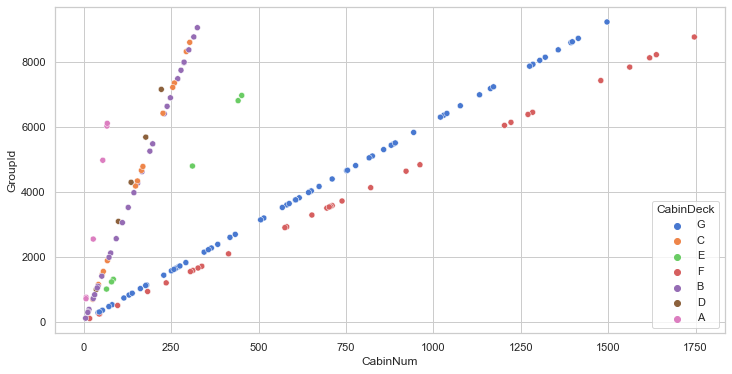

In [80]:
fig, axs = plt.subplots(figsize=(12, 6))

sns.scatterplot(data=X_train.loc[null_cabin_num_ind, :], x='CabinNum', y='GroupId', hue='CabinDeck', ax=axs)

### CabinSide

In [81]:
tmp = X_train.loc[X_train['CabinSide'].notnull(), ['GroupId', 'CabinSide']].groupby(['GroupId'], as_index=False).agg(
                        not_null_cabin_side = ('CabinSide', lambda x: len(x.value_counts()))).sort_values('not_null_cabin_side')  


tmp.groupby('not_null_cabin_side').size()

not_null_cabin_side
1    5139
dtype: int64

In [82]:
def CabinSide_update(df, source_data):
    print('------ CabinSide_update ------------')
    print('CabinSide NULLs:', df.loc[df['CabinSide'].isnull()].shape[0])
    
    cabin_side_for_group_id_df = source_data.loc[
            source_data['CabinSide'].notnull(), :].groupby(['GroupId'], as_index=False).agg(
                                not_null_cabin_side = ('CabinSide', lambda x: x.unique()[0]))
    
    df['CabinSide'] = df.apply(
    lambda x: 
        (cabin_side_for_group_id_df.loc[cabin_side_for_group_id_df['GroupId'] == x.GroupId, 'not_null_cabin_side'].iloc[0] if cabin_side_for_group_id_df.loc[cabin_side_for_group_id_df['GroupId'] == x.GroupId, 'not_null_cabin_side'].shape[0] > 0 else np.nan)
        if x.CabinSide is np.nan else x.CabinSide , axis=1)
    
    print('CabinSide NULLs:', df.loc[df['CabinSide'].isnull()].shape[0])
    
    #-----------------------------------------------------
    
    df.fillna(value= {'CabinSide': 'O'}, inplace=True)
    print('CabinSide NULLs:', df.loc[df['CabinSide'].isnull()].shape[0])
    
    return df
    
X_train = CabinSide_update(X_train, for_visual_df)

------ CabinSide_update ------------
CabinSide NULLs: 157
CabinSide NULLs: 81
CabinSide NULLs: 0


In [83]:
X_train.CabinSide.unique()

array(['S', 'P', 'O'], dtype=object)

### VIP             

In [84]:
def VIP_update(df):
    print('------ VIP_update ------------')
    print('VIP NULLs:', df.loc[df['VIP'].isnull()].shape[0])
    
    df.fillna(value= {'VIP': False}, inplace=True)
    
    print('VIP NULLs:', df.loc[df['VIP'].isnull()].shape[0])
    
    return df
    
    
X_train = VIP_update(X_train)

------ VIP_update ------------
VIP NULLs: 166
VIP NULLs: 0


### CryoSleep

In [85]:
for_visual_df.loc[
    (for_visual_df['CryoSleep'].notnull())
    & (for_visual_df['CryoSleep'])
    & (for_visual_df['TotalSpend'].notnull()), 'TotalSpend'].sum()

0.0

In [86]:
def CryoSleep_update(df):
    print('------ CryoSleep_update ------------')
    print(df.loc[df['CryoSleep'].isnull(), :].shape[0])
    
    df.loc[(df['CryoSleep'].isnull()) & (df['TotalSpend'] == 0), 'CryoSleep'] = True
    
    print(df.loc[df['CryoSleep'].isnull(), :].shape[0])
    
    #------------------------------------------------------------
    
    df.fillna(value= {'CryoSleep': False}, inplace=True)
    print(df.loc[df['CryoSleep'].isnull(), :].shape[0])
    
    return df
    
X_train = CryoSleep_update(X_train)    

------ CryoSleep_update ------------
165
101
0


### Age

In [87]:
def get_age_medians(df):

    return df.loc[:, ['IsSingle', 'HomePlanet', 'VIP', 'Age']].groupby(
        ['IsSingle', 'HomePlanet', 'VIP'], 
        as_index=False).agg('median')

In [88]:
def Age_update(df, median_values):
    print('------ Age_update ------------')
    print('Nulls in Expenses:', df.loc[:, 'Age'].isna().sum())
    
    for index, row in median_values.iterrows():
        
        cond = (df['IsSingle'] == row['IsSingle']) & (df['VIP'] == row['VIP']) & (df['HomePlanet'] == row['HomePlanet'])
        
        df.loc[cond, :] = df.loc[cond, :].fillna(value = {'Age': row['Age']})

    print('Nulls in Expenses:', df.loc[:, 'Age'].isna().sum())   
    
    #-----------------------------------------------------------------------------
    
    df.fillna(value= {'Age': 0}, inplace=True)
    print('Nulls in Expenses:', df.loc[:, 'Age'].isna().sum())
    
    return df

age_medians_train = get_age_medians(X_train)

X_train = Age_update(X_train, age_medians_train)

------ Age_update ------------
Nulls in Expenses: 154
Nulls in Expenses: 0
Nulls in Expenses: 0


### Expenses ("RoomService", "FoodCourt", "ShoppingMall", "Spa", 'VRDeck')

In [89]:
group_cols = ['IsSingle', 'VIP', 'HomePlanet']
cols= expenses_cols + group_cols

not_child_not_sleep_df = X_train.loc[(X_train['Age'] >= 13) & (X_train['CryoSleep'] == False), :]
print(not_child_not_sleep_df.shape)


no_spend_df = not_child_not_sleep_df.loc[
    (not_child_not_sleep_df['ShoppingMall']==0) &
    (not_child_not_sleep_df['FoodCourt']==0) &
    (not_child_not_sleep_df['RoomService']==0) &
    (not_child_not_sleep_df['Spa']==0) &
    (not_child_not_sleep_df['VRDeck']==0), :
]

print(no_spend_df.shape)
    
expenses_means = not_child_not_sleep_df.loc[:, cols].groupby(group_cols, as_index=False).agg('mean')
expenses_means

(4122, 26)
(80, 26)


IsSingle    VIP HomePlanet  RoomService    FoodCourt  ShoppingMall  \
0     False  False      Earth   232.229602   219.576923    206.981025   
1     False  False     Europa   302.703704  2587.694323    289.389868   
2     False  False       Mars  1016.549153   106.812081    510.896907   
3     False   True     Europa   438.547170  2905.092593    188.452830   
4     False   True       Mars   874.750000   146.750000    657.210526   
5      True  False      Earth   217.863158   217.633958    211.233844   
6      True  False     Europa   203.042017  2618.831933    288.394958   
7      True  False       Mars   990.223214   101.777778    583.811947   
8      True   True     Europa   359.055556  2992.617647    223.971429   
9      True   True       Mars   860.062500   108.516129    358.878788   

           Spa       VRDeck  
0   245.934489   215.865275  
1  1612.439560  1593.158242  
2   196.180272    90.174497  
3  1220.000000  2686.283019  
4   176.476190    44.000000  
5   220.979006   214.701048  
6  1474.092697  1547.339833  
7   167.164080    91.442953  
8  1439.722222  1835.472222  
9   231.303030    51.848485

In [90]:
expenses_medians = not_child_not_sleep_df.loc[:, cols].groupby(group_cols, as_index=False).agg('median')
expenses_medians

IsSingle    VIP HomePlanet  RoomService  FoodCourt  ShoppingMall    Spa  \
0     False  False      Earth          5.0        4.0           4.0    2.0   
1     False  False     Europa          0.0     1421.0           0.0  445.0   
2     False  False       Mars        853.0        0.0         170.0    0.0   
3     False   True     Europa          0.0     1525.0           0.0  417.0   
4     False   True       Mars        788.0        0.0         354.0    4.0   
5      True  False      Earth          3.0        4.0           4.0    6.0   
6      True  False     Europa          0.0     1389.0           0.0  272.5   
7      True  False       Mars        726.5        0.0         268.0    0.0   
8      True   True     Europa          0.0     2343.0           0.0  269.0   
9      True   True       Mars        687.5        0.0         177.0    0.0   

   VRDeck  
0     7.0  
1   473.0  
2     0.0  
3  1547.0  
4     0.0  
5     4.0  
6   438.0  
7     0.0  
8   680.0  
9     0.0

In [91]:
for index, row in expenses_medians.iterrows():
    print(row[expenses_cols].to_dict())
    print('---------------------------')

{'RoomService': 5.0, 'FoodCourt': 4.0, 'ShoppingMall': 4.0, 'Spa': 2.0, 'VRDeck': 7.0}
---------------------------
{'RoomService': 0.0, 'FoodCourt': 1421.0, 'ShoppingMall': 0.0, 'Spa': 445.0, 'VRDeck': 473.0}
---------------------------
{'RoomService': 853.0, 'FoodCourt': 0.0, 'ShoppingMall': 170.0, 'Spa': 0.0, 'VRDeck': 0.0}
---------------------------
{'RoomService': 0.0, 'FoodCourt': 1525.0, 'ShoppingMall': 0.0, 'Spa': 417.0, 'VRDeck': 1547.0}
---------------------------
{'RoomService': 788.0, 'FoodCourt': 0.0, 'ShoppingMall': 354.0, 'Spa': 4.0, 'VRDeck': 0.0}
---------------------------
{'RoomService': 3.0, 'FoodCourt': 4.0, 'ShoppingMall': 4.0, 'Spa': 6.0, 'VRDeck': 4.0}
---------------------------
{'RoomService': 0.0, 'FoodCourt': 1389.0, 'ShoppingMall': 0.0, 'Spa': 272.5, 'VRDeck': 438.0}
---------------------------
{'RoomService': 726.5, 'FoodCourt': 0.0, 'ShoppingMall': 268.0, 'Spa': 0.0, 'VRDeck': 0.0}
---------------------------
{'RoomService': 0.0, 'FoodCourt': 2343.0, 'Sho

In [92]:
def get_expenses_means(df):
    not_child_not_sleep_df = df.loc[(X_train['Age'] >= 13) & (df['CryoSleep'] == False), :]
    
    expenses_means = not_child_not_sleep_df.loc[:, cols].groupby(group_cols, as_index=False).agg('mean')
    return expenses_means

In [93]:
def Expenses_update(df, median_values):
    print('------ Expenses_update ------------')
    values = {"RoomService": 0, "FoodCourt": 0, "ShoppingMall": 0, "Spa": 0, 'VRDeck': 0}
    

    print('Nulls in Expenses:', df.loc[:, expenses_cols].isna().sum().sum(axis = 0))
    
    df.loc[(df['Age'] < 13), :] = df.loc[(df['Age'] < 13), :].fillna(value = values)
    
    print('Nulls in Expenses:', df.loc[:, expenses_cols].isna().sum().sum(axis = 0))
    #-------------------------------------------------------------------------------
    
    df.loc[(df['CryoSleep'].notnull())
           & (df['CryoSleep']), :] = df.loc[(df['CryoSleep'].notnull()) & (df['CryoSleep']), :].fillna(value = values)
    
    print('Nulls in Expenses:', df.loc[:, expenses_cols].isna().sum().sum(axis = 0))
    
    #-------------------------------------------------------------------------
    
    for index, row in median_values.iterrows():
        
        cond = (df['IsSingle'] == row['IsSingle']) & (df['VIP'] == row['VIP']) & (df['HomePlanet'] == row['HomePlanet'])
        
        tmp = df.loc[cond, expenses_cols]
        print(tmp.shape)
        
        df.loc[cond, :] = df.loc[cond, :].fillna(value = row[expenses_cols].to_dict())

    print('Nulls in Expenses:', df.loc[:, expenses_cols].isna().sum().sum(axis = 0))   
    
    #-----------------------------------------------------------------------------
    
    df.fillna(value= values, inplace=True)
    print('Nulls in Expenses:', df.loc[:, expenses_cols].isna().sum().sum(axis = 0))
    
    return df

expenses_means_train = get_expenses_means(X_train)

X_train = Expenses_update(X_train, expenses_means_train)

------ Expenses_update ------------
Nulls in Expenses: 755
Nulls in Expenses: 681
Nulls in Expenses: 426
(1177, 5)
(923, 5)
(615, 5)
(64, 5)
(21, 5)
(2624, 5)
(683, 5)
(770, 5)
(44, 5)
(33, 5)
Nulls in Expenses: 0
Nulls in Expenses: 0


In [94]:
def log_expenses(df):
    print('------ log_expenses ------------')
    num_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' ]

    for f in num_features:
        df[f] = np.log10(df[f] + 1)
        
    return df
        
X_train = log_expenses(X_train)

------ log_expenses ------------


In [95]:
def New_features_update(df):
    print('------ New_features_update ------------')
    df['TotalSpend'] = df.loc[:, expenses_cols].sum(axis=1)
    df['NoSpend'] = df.loc[:, 'TotalSpend'].apply(lambda x: np.nan if math.isnan(x) else x==0)
    df['IsChild'] = df.loc[:, 'Age'] < 18
    df['Route'] = df['HomePlanet'] + ' - ' + df['Destination']
    
    return df
    
X_train = New_features_update(X_train)

------ New_features_update ------------


In [96]:
X_train.isnull().sum()

PassengerId                 0
HomePlanet                  0
CryoSleep                   0
Cabin                     157
Destination                 0
Age                         0
VIP                         0
RoomService                 0
FoodCourt                   0
ShoppingMall                0
Spa                         0
VRDeck                      0
Name                       95
FirstName                 165
LastName                   95
GroupId                     0
NumInGroup                  0
CabinDeck                   0
CabinNum                    0
CabinSide                   0
IsChild                     0
TotalSpend                  0
GroupSize                   0
IsSingle                    0
namesakes_num_in_group      0
NameLength                  0
NoSpend                     0
Route                       0
dtype: int64

In [97]:
X_train.drop(['Cabin', 'PassengerId', 'Name', 'FirstName', 'LastName'], axis=1, inplace=True)

In [98]:
X_train.describe()

Age  RoomService    FoodCourt  ShoppingMall          Spa  \
count  6954.000000  6954.000000  6954.000000   6954.000000  6954.000000   
mean     28.704630     0.792112     0.853224      0.726385     0.818248   
std      14.320889     1.200016     1.277488      1.129154     1.205654   
min       0.000000     0.000000     0.000000      0.000000     0.000000   
25%      19.000000     0.000000     0.000000      0.000000     0.000000   
50%      27.000000     0.000000     0.000000      0.000000     0.000000   
75%      37.000000     1.819544     1.959041      1.518514     1.812913   
max      79.000000     3.996555     4.474420      4.370938     4.350422   

            VRDeck      GroupId   NumInGroup     CabinNum   TotalSpend  \
count  6954.000000  6954.000000  6954.000000  6954.000000  6954.000000   
mean      0.783067  4628.054357     1.522577   599.634978     3.973037   
std       1.200326  2662.087544     1.064101   508.683487     3.802163   
min       0.000000     1.000000     1.000000     0.000000     0.000000   
25%       0.000000  2308.000000     1.000000   170.000000     0.000000   
50%       0.000000  4643.000000     1.000000   428.500000     4.446009   
75%       1.724276  6864.000000     2.000000   998.000000     7.003803   
max       4.382629  9280.000000     8.000000  1891.000000    17.251366   

         GroupSize  namesakes_num_in_group   NameLength  
count  6954.000000             6954.000000  6954.000000  
mean      1.838079                0.669255    13.583405  
std       1.373543                1.152245     3.057250  
min       1.000000                0.000000     0.000000  
25%       1.000000                0.000000    12.000000  
50%       1.000000                0.000000    14.000000  
75%       2.000000                1.000000    16.000000  
max       8.000000                6.000000    18.000000

In [99]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6954 entries, 0 to 6953
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   HomePlanet              6954 non-null   object 
 1   CryoSleep               6954 non-null   bool   
 2   Destination             6954 non-null   object 
 3   Age                     6954 non-null   float64
 4   VIP                     6954 non-null   bool   
 5   RoomService             6954 non-null   float64
 6   FoodCourt               6954 non-null   float64
 7   ShoppingMall            6954 non-null   float64
 8   Spa                     6954 non-null   float64
 9   VRDeck                  6954 non-null   float64
 10  GroupId                 6954 non-null   float64
 11  NumInGroup              6954 non-null   float64
 12  CabinDeck               6954 non-null   object 
 13  CabinNum                6954 non-null   float64
 14  CabinSide               6954 non-null   

In [100]:
def bool_to_int(df):
    print('------ bool_to_int ------------')
    df['CryoSleep'] = df["CryoSleep"].astype(int)
    df['VIP'] = df["VIP"].astype(int)
    df['IsChild'] = df["IsChild"].astype(int)
    df['IsSingle'] = df["IsSingle"].astype(int)
    df['NoSpend'] = df["NoSpend"].astype(int)
    
    return df

X_train = bool_to_int(X_train)

------ bool_to_int ------------


In [101]:
# ---------------------------------------------------------------------------------------------

In [102]:
df_test = pd.read_csv("test.csv", sep=',', engine='python')
df_test

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
4272     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth     False       NaN    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars      True   D/296/P    55 Cancri e   NaN  False   
4275     9273_01     Europa     False   D/297/P            NaN   NaN  False   
4276     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0             0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1             0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2             0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3             0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4            10.0        0.0         635.0     0.0     0.0   Brence Harperez  
...           ...        ...           ...     ...     ...               ...  
4272          0.0        0.0           0.0     0.0     0.0       Jeron Peter  
4273          0.0      847.0          17.0    10.0   144.0     Matty Scheron  
4274          0.0        0.0           0.0     0.0     0.0       Jayrin Pore  
4275          0.0     2680.0           0.0     0.0   523.0    Kitakan Conale  
4276          0.0        0.0           0.0     0.0     0.0  Lilace Leonzaley  

[4277 rows x 13 columns]

In [103]:
df_test[['GroupId', 'NumInGroup']] = df_test['PassengerId'].str.split('_', expand=True)
df_test['GroupId'] = df_test.loc[:,'GroupId'].astype(float) 

In [104]:
pd.merge(X_train, df_test, how ='inner', on =['GroupId', 'GroupId'])

Empty DataFrame
Columns: [HomePlanet_x, CryoSleep_x, Destination_x, Age_x, VIP_x, RoomService_x, FoodCourt_x, ShoppingMall_x, Spa_x, VRDeck_x, GroupId, NumInGroup_x, CabinDeck, CabinNum, CabinSide, IsChild, TotalSpend, GroupSize, IsSingle, namesakes_num_in_group, NameLength, NoSpend, Route, PassengerId, HomePlanet_y, CryoSleep_y, Cabin, Destination_y, Age_y, VIP_y, RoomService_y, FoodCourt_y, ShoppingMall_y, Spa_y, VRDeck_y, Name, NumInGroup_y]
Index: []

[0 rows x 37 columns]

In [105]:
def encode_data(df):
    numeric_selector = make_column_selector(dtype_include=np.number)
    numeric_columns = numeric_selector(X_train)
    print(numeric_columns)

    
    nominal_columns = ["HomePlanet", "Destination", 'CabinSide', 'CabinDeck', 'Route']
    nominal_categories = [list(sorted(X_train[column].unique())) for column in nominal_columns]

    print(nominal_categories)

    nominal_encoder = OneHotEncoder(categories=nominal_categories, sparse=False)
    nominal_encoder.fit(X_train.loc[:, nominal_columns])
    X_train_nominal = nominal_encoder.transform(X_train.loc[:, nominal_columns])
    X_train_nominal = pd.DataFrame(
        X_train_nominal,
        columns=nominal_encoder.get_feature_names(),
        index=X_train.index
    )
    
    X_train = pd.concat((X_train_nominal, X_train.drop(columns=nominal_columns)), axis=1)

    # numerische features skalieren
    scaler = MinMaxScaler()
    scaler.fit(X_train[numeric_columns])
    X_train.loc[:, numeric_columns] = scaler.transform(X_train[numeric_columns])

    # Box Plot erzeugen
    plt.figure(figsize=(15, 8))
    X_train.loc[:, numeric_columns].boxplot(rot=90)

In [106]:
numeric_selector = make_column_selector(dtype_include=np.number)
numeric_columns = numeric_selector(X_train)
numeric_columns

['CryoSleep',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'GroupId',
 'NumInGroup',
 'CabinNum',
 'IsChild',
 'TotalSpend',
 'GroupSize',
 'IsSingle',
 'namesakes_num_in_group',
 'NameLength',
 'NoSpend']

In [107]:
nominal_columns = ["HomePlanet", "Destination", 'CabinSide', 'CabinDeck', 'Route']
nominal_categories = [list(sorted(X_train[column].unique())) for column in nominal_columns]

print(nominal_categories)

nominal_encoder = OneHotEncoder(categories=nominal_categories, sparse=False)
nominal_encoder.fit(X_train.loc[:, nominal_columns])
X_train_nominal = nominal_encoder.transform(X_train.loc[:, nominal_columns])
X_train_nominal = pd.DataFrame(
    X_train_nominal,
    columns=nominal_encoder.get_feature_names(),
    index=X_train.index
)
X_train_nominal


[['Earth', 'Europa', 'Mars'], ['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], ['O', 'P', 'S'], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], ['Earth - 55 Cancri e', 'Earth - PSO J318.5-22', 'Earth - TRAPPIST-1e', 'Europa - 55 Cancri e', 'Europa - PSO J318.5-22', 'Europa - TRAPPIST-1e', 'Mars - 55 Cancri e', 'Mars - PSO J318.5-22', 'Mars - TRAPPIST-1e']]


x0_Earth  x0_Europa  x0_Mars  x1_55 Cancri e  x1_PSO J318.5-22  \
0          1.0        0.0      0.0             0.0               0.0   
1          1.0        0.0      0.0             0.0               0.0   
2          1.0        0.0      0.0             0.0               0.0   
3          1.0        0.0      0.0             0.0               0.0   
4          1.0        0.0      0.0             1.0               0.0   
...        ...        ...      ...             ...               ...   
6949       1.0        0.0      0.0             0.0               1.0   
6950       1.0        0.0      0.0             0.0               0.0   
6951       0.0        0.0      1.0             0.0               0.0   
6952       0.0        1.0      0.0             0.0               0.0   
6953       0.0        1.0      0.0             1.0               0.0   

      x1_TRAPPIST-1e  x2_O  x2_P  x2_S  x3_A  ...  x3_T  \
0                1.0   0.0   0.0   1.0   0.0  ...   0.0   
1                1.0   0.0   0.0   1.0   0.0  ...   0.0   
2                1.0   0.0   0.0   1.0   0.0  ...   0.0   
3                1.0   0.0   0.0   1.0   0.0  ...   0.0   
4                0.0   0.0   1.0   0.0   0.0  ...   0.0   
...              ...   ...   ...   ...   ...  ...   ...   
6949             0.0   0.0   0.0   1.0   0.0  ...   0.0   
6950             1.0   0.0   1.0   0.0   0.0  ...   0.0   
6951             1.0   0.0   0.0   1.0   0.0  ...   0.0   
6952             1.0   0.0   0.0   1.0   0.0  ...   0.0   
6953             0.0   0.0   1.0   0.0   0.0  ...   0.0   

      x4_Earth - 55 Cancri e  x4_Earth - PSO J318.5-22  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        1.0                       0.0   
...                      ...                       ...   
6949                     0.0                       1.0   
6950                     0.0                       0.0   
6951                     0.0                       0.0   
6952                     0.0                       0.0   
6953                     0.0                       0.0   

      x4_Earth - TRAPPIST-1e  x4_Europa - 55 Cancri e  \
0                        1.0                      0.0   
1                        1.0                      0.0   
2                        1.0                      0.0   
3                        1.0                      0.0   
4                        0.0                      0.0   
...                      ...                      ...   
6949                     0.0                      0.0   
6950                     1.0                      0.0   
6951                     0.0                      0.0   
6952                     0.0                      0.0   
6953                     0.0                      1.0   

      x4_Europa - PSO J318.5-22  x4_Europa - TRAPPIST-1e  \
0                           0.0                      0.0   
1                           0.0                      0.0   
2                           0.0                      0.0   
3                           0.0                      0.0   
4                           0.0                      0.0   
...                         ...                      ...   
6949                        0.0                      0.0   
6950                        0.0                      0.0   
6951                        0.0                      0.0   
6952                        0.0                      1.0   
6953                        0.0                      0.0   

      x4_Mars - 55 Cancri e  x4_Mars - PSO J318.5-22  x4_Mars - TRAPPIST-1e  
0                       0.0                      0.0                    0.0  
1                       0.0                      0.0                    0.0  
2                       0.0                      0.0                    0.0  
3                

In [108]:
X_train = pd.concat((X_train_nominal, X_train.drop(columns=nominal_columns)), axis=1)
X_train.head()

x0_Earth  x0_Europa  x0_Mars  x1_55 Cancri e  x1_PSO J318.5-22  \
0       1.0        0.0      0.0             0.0               0.0   
1       1.0        0.0      0.0             0.0               0.0   
2       1.0        0.0      0.0             0.0               0.0   
3       1.0        0.0      0.0             0.0               0.0   
4       1.0        0.0      0.0             1.0               0.0   

   x1_TRAPPIST-1e  x2_O  x2_P  x2_S  x3_A  ...  GroupId  NumInGroup  CabinNum  \
0             1.0   0.0   0.0   1.0   0.0  ...   6309.0         2.0    1023.0   
1             1.0   0.0   0.0   1.0   0.0  ...   2908.0         2.0     553.0   
2             1.0   0.0   0.0   1.0   0.0  ...    548.0         1.0      36.0   
3             1.0   0.0   0.0   1.0   0.0  ...   8757.0         1.0    1409.0   
4             0.0   0.0   1.0   0.0   0.0  ...   1644.0         1.0     327.0   

   IsChild  TotalSpend  GroupSize  IsSingle  namesakes_num_in_group  \
0        1    0.000000          4         0                     2.0   
1        1    7.545307          1         1                     0.0   
2        0    5.088738          1         1                     0.0   
3        0    6.575190          1         1                     0.0   
4        1    3.377488          1         1                     0.0   

   NameLength  NoSpend  
0        15.0        1  
1        16.0        0  
2        14.0        0  
3        13.0        0  
4        16.0        0  

[5 rows x 44 columns]

<AxesSubplot:>

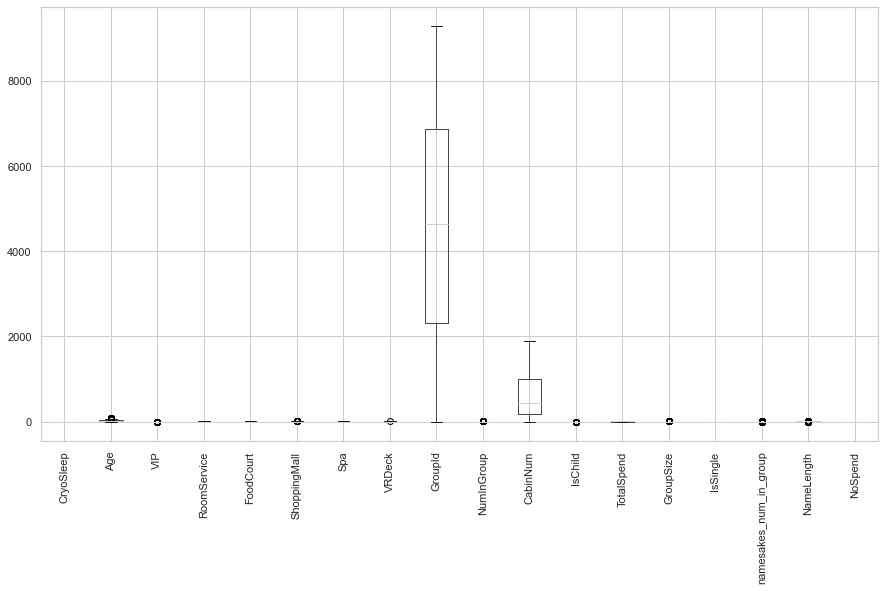

In [109]:
# numeric_columns.append('CabinDeck')

# Box Plot erzeugen
plt.figure(figsize=(15, 8))
X_train[numeric_columns].boxplot(rot=90)

<AxesSubplot:>

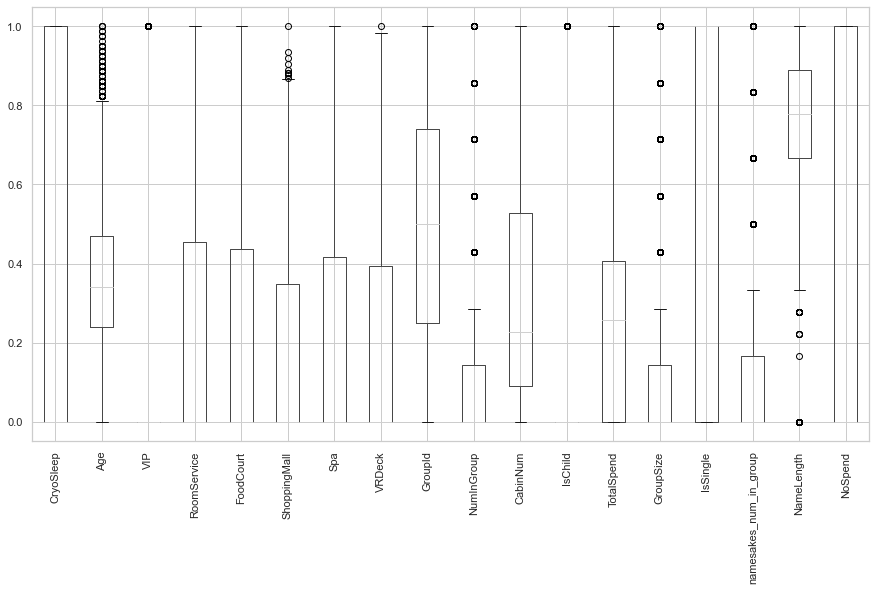

In [110]:
# numerische features skalieren
scaler = MinMaxScaler()
scaler.fit(X_train[numeric_columns])
X_train.loc[:, numeric_columns] = scaler.transform(X_train[numeric_columns])

# Box Plot erzeugen
plt.figure(figsize=(15, 8))
X_train.loc[:, numeric_columns].boxplot(rot=90)

In [111]:
X_train

x0_Earth  x0_Europa  x0_Mars  x1_55 Cancri e  x1_PSO J318.5-22  \
0          1.0        0.0      0.0             0.0               0.0   
1          1.0        0.0      0.0             0.0               0.0   
2          1.0        0.0      0.0             0.0               0.0   
3          1.0        0.0      0.0             0.0               0.0   
4          1.0        0.0      0.0             1.0               0.0   
...        ...        ...      ...             ...               ...   
6949       1.0        0.0      0.0             0.0               1.0   
6950       1.0        0.0      0.0             0.0               0.0   
6951       0.0        0.0      1.0             0.0               0.0   
6952       0.0        1.0      0.0             0.0               0.0   
6953       0.0        1.0      0.0             1.0               0.0   

      x1_TRAPPIST-1e  x2_O  x2_P  x2_S  x3_A  ...   GroupId  NumInGroup  \
0                1.0   0.0   0.0   1.0   0.0  ...  0.679815    0.142857   
1                1.0   0.0   0.0   1.0   0.0  ...  0.313288    0.142857   
2                1.0   0.0   0.0   1.0   0.0  ...  0.058950    0.000000   
3                1.0   0.0   0.0   1.0   0.0  ...  0.943636    0.000000   
4                0.0   0.0   1.0   0.0   0.0  ...  0.177066    0.000000   
...              ...   ...   ...   ...   ...  ...       ...         ...   
6949             0.0   0.0   0.0   1.0   0.0  ...  0.155620    0.000000   
6950             1.0   0.0   1.0   0.0   0.0  ...  0.106261    0.000000   
6951             1.0   0.0   0.0   1.0   0.0  ...  0.494773    0.285714   
6952             1.0   0.0   0.0   1.0   0.0  ...  0.650393    0.142857   
6953             0.0   0.0   1.0   0.0   0.0  ...  0.061429    0.000000   

      CabinNum  IsChild  TotalSpend  GroupSize  IsSingle  \
0     0.540984      1.0    0.000000   0.428571       0.0   
1     0.292438      1.0    0.437374   0.000000       1.0   
2     0.019038      0.0    0.294976   0.000000       1.0   
3     0.745108      0.0    0.381140   0.000000       1.0   
4     0.172924      1.0    0.195781   0.000000       1.0   
...        ...      ...         ...        ...       ...   
6949  0.116869      1.0    0.000000   0.000000       1.0   
6950  0.107879      1.0    0.406790   0.000000       1.0   
6951  0.455843      0.0    0.000000   0.428571       0.0   
6952  0.118985      1.0    0.497925   0.285714       0.0   
6953  0.011105      0.0    0.000000   0.571429       0.0   

      namesakes_num_in_group  NameLength  NoSpend  
0                   0.333333    0.833333      1.0  
1                   0.000000    0.888889      0.0  
2                   0.000000    0.777778      0.0  
3                   0.000000    0.722222      0.0  
4                   0.000000    0.888889      0.0  
...                      ...         ...      ...  
6949                0.000000    0.833333      1.0  
6950                0.000000    0.777778      0.0  
6951                0.500000    0.611111      1.0  
6952                0.333333    0.888889      0.0  
6953                0.666667    0.777778      1.0  

[6954 rows x 44 columns]

## Speicherplatz Optimierung

In [112]:
X_train.dtypes

x0_Earth                     float64
x0_Europa                    float64
x0_Mars                      float64
x1_55 Cancri e               float64
x1_PSO J318.5-22             float64
x1_TRAPPIST-1e               float64
x2_O                         float64
x2_P                         float64
x2_S                         float64
x3_A                         float64
x3_B                         float64
x3_C                         float64
x3_D                         float64
x3_E                         float64
x3_F                         float64
x3_G                         float64
x3_T                         float64
x4_Earth - 55 Cancri e       float64
x4_Earth - PSO J318.5-22     float64
x4_Earth - TRAPPIST-1e       float64
x4_Europa - 55 Cancri e      float64
x4_Europa - PSO J318.5-22    float64
x4_Europa - TRAPPIST-1e      float64
x4_Mars - 55 Cancri e        float64
x4_Mars - PSO J318.5-22      float64
x4_Mars - TRAPPIST-1e        float64
CryoSleep                    float64
A

In [113]:
X_train.memory_usage(deep= True)

Index                        319864
x0_Earth                      55632
x0_Europa                     55632
x0_Mars                       55632
x1_55 Cancri e                55632
x1_PSO J318.5-22              55632
x1_TRAPPIST-1e                55632
x2_O                          55632
x2_P                          55632
x2_S                          55632
x3_A                          55632
x3_B                          55632
x3_C                          55632
x3_D                          55632
x3_E                          55632
x3_F                          55632
x3_G                          55632
x3_T                          55632
x4_Earth - 55 Cancri e        55632
x4_Earth - PSO J318.5-22      55632
x4_Earth - TRAPPIST-1e        55632
x4_Europa - 55 Cancri e       55632
x4_Europa - PSO J318.5-22     55632
x4_Europa - TRAPPIST-1e       55632
x4_Mars - 55 Cancri e         55632
x4_Mars - PSO J318.5-22       55632
x4_Mars - TRAPPIST-1e         55632
CryoSleep                   

In [114]:
def memory_optimiz(df):
    print('------ memory_optimiz ------------')
    df_opti = df.apply(pd.to_numeric, downcast="float")
    
    reduction = (df.memory_usage(deep=True).sum()-df_opti.memory_usage(deep=True).sum())/df.memory_usage(deep=True).sum() *  100

    print(f"Reduction = {reduction:0.2f}%")
    
    return df_opti

In [115]:
X_train = memory_optimiz(X_train)

------ memory_optimiz ------------
Reduction = 44.22%


## Correlationsmatrix

<AxesSubplot:>

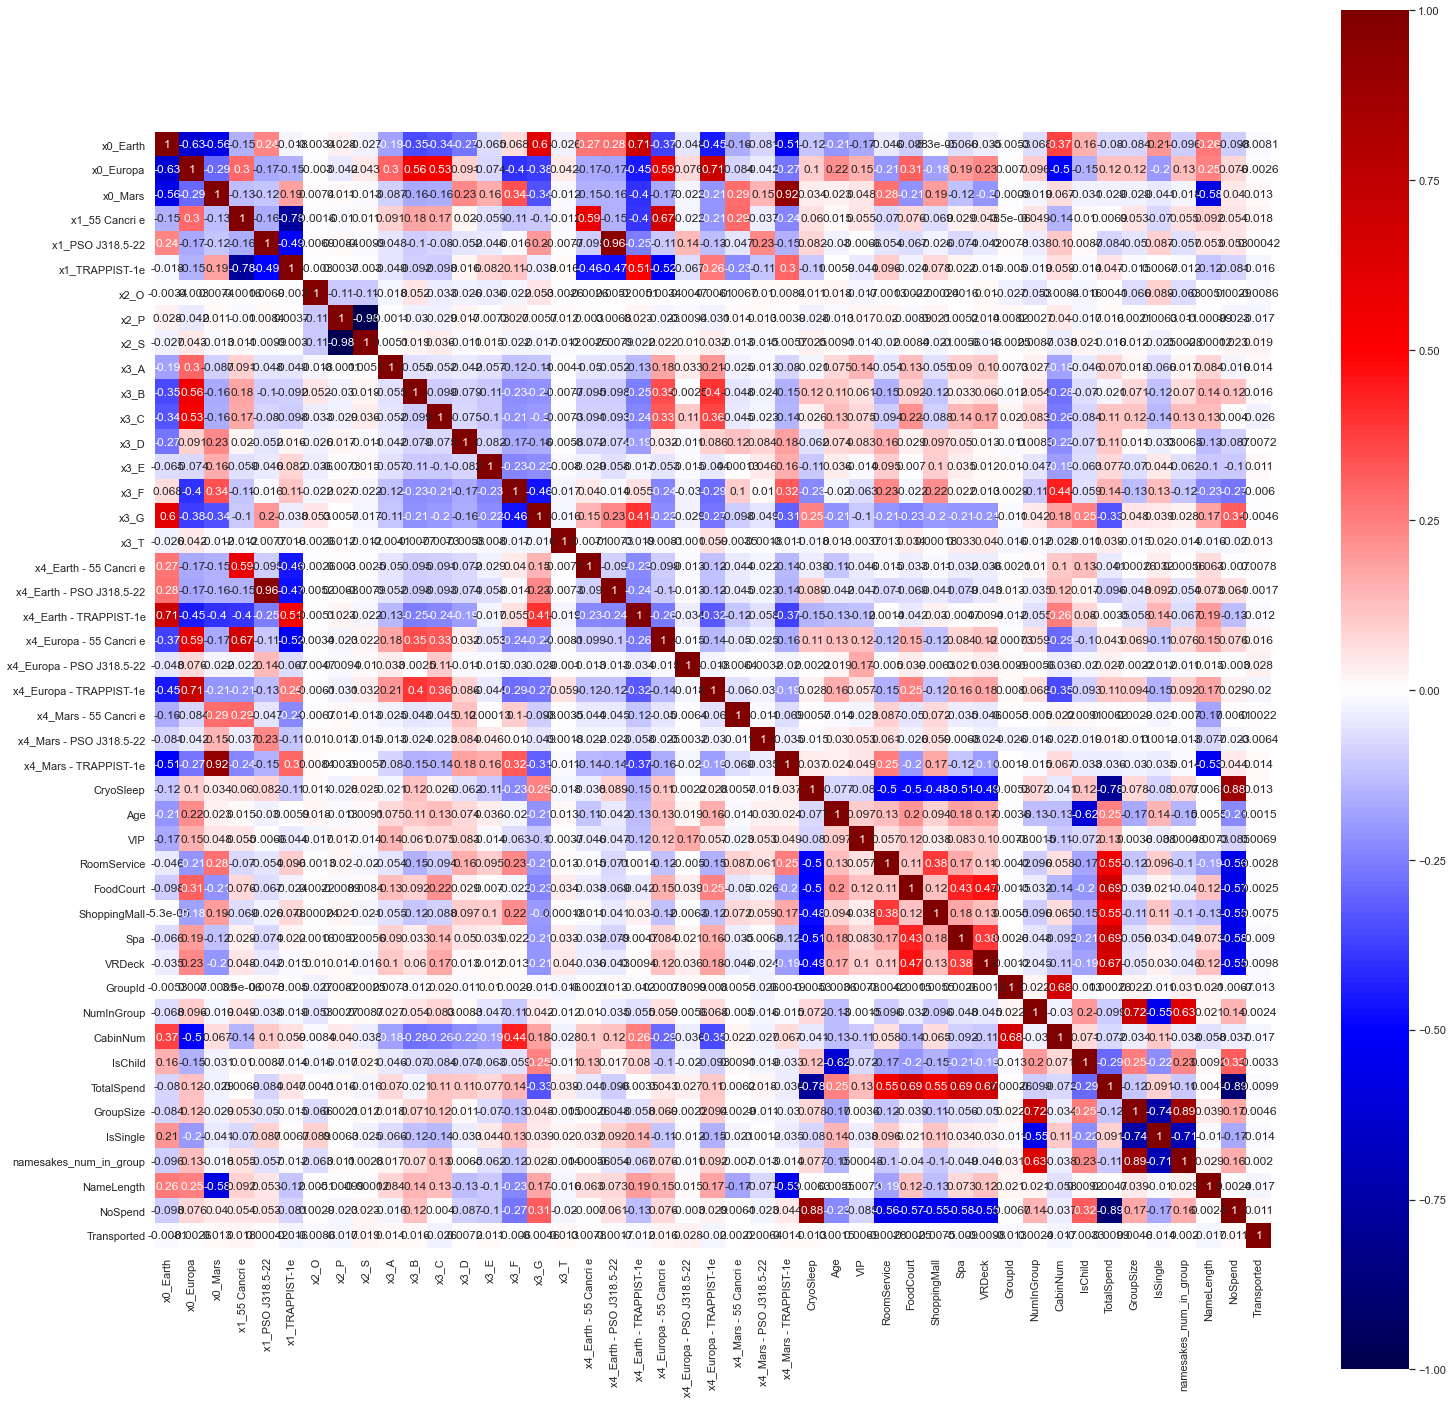

In [116]:
X_train_tmp = X_train.copy()
X_train_tmp['Transported'] = y_train

corrmat = X_train_tmp.corr()

fig = plt.figure(figsize=(25, 25))
sns.heatmap(corrmat, vmax=1, vmin=-1, square=True, cmap="seismic", annot=True)

## Test Daten Vorbereitung

In [117]:
def data_transform(df, source_data, *args):
    
    age_medians = []
    expenses_means = []
    df = new_features_create(df)
    
    df = HomePlanet_update(df, source_data)
    df= Destination_update(df)
    df = LastName_update(df)
    df = CabinDeck_update(df)   
    null_cabin_num_ind, df = CabinNum_update(df, source_data)
    df = CabinSide_update(df, source_data)
    df = VIP_update(df)
    df = CryoSleep_update(df)
      
    if len(args) == 0:
        age_medians = get_age_medians(df)
        expenses_means = get_expenses_means(df)
    else:
        age_medians = args[0]
        expenses_means = args[1]  
    
    df = Age_update(df, age_medians)
    df = Expenses_update(df, expenses_means)
        
    df = log_expenses(df)
    df = New_features_update(df)

    df.drop(['Cabin', 'PassengerId', 'Name', 'FirstName', 'LastName'], axis=1, inplace=True)
    
    df = bool_to_int(df)
    
    return df, age_medians, expenses_means

In [118]:
def encode_data(df, nominal_encoder, scaler):

    df_nominal = nominal_encoder.transform(df.loc[:, nominal_columns])
    df_nominal = pd.DataFrame(
        df_nominal,
        columns=nominal_encoder.get_feature_names(),
        index=df.index
    )
    df_nominal


    df = pd.concat((df_nominal, df.drop(columns=nominal_columns)), axis=1)


    df.loc[:, numeric_columns] = scaler.transform(df[numeric_columns])
    
    return df

In [119]:
X_test, am, em = data_transform(X_test, for_visual_df, age_medians_train, expenses_means_train)
X_test = encode_data(X_test, nominal_encoder, scaler)
X_test = memory_optimiz(X_test)


------ HomePlanet_update ------------
HomePlanet NULLs: 35
1. (after replacement through the GroupId) HomePlanet NULLs: 17
2. (after replacement through the Deck) HomePlanet NULLs: 9
3. (after replacement through the LastName) HomePlanet NULLs: 1
4. (after replacement through the Destination): 0
5. (after replacement by the most common value) HomePlanet NULLs: 0
------ Destination_update ------------
Destination NULLs: 29
(after replacement by the most common value) Destination NULLs: 0
------ LastName_update ------------
LastName NULLs: 35
(1554, 2)
(after update) LastName NULLs: 29
namesakes_num_in_group NULLs: 29
namesakes_num_in_group NULLs: 0
------ CabinDeck_update ------------
CabinDeck NULLs: 42
(after update throw GroupId) CabinDeck NULLs: 30
(after update throw HomePlanet) CabinDeck NULLs: 0
------ CabinNum_update ------------
CabinNum NULLs: 42
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
B (10, 1)
F (8, 1)
G (24, 1)
CabinNum NULLs: 0
------ CabinSide_update ------------
CabinSi

In [120]:
data = pd.read_csv("train.csv", sep=',', engine='python')

In [121]:
X, age_medians_all, expenses_means_all = data_transform(data.drop(columns="Transported"), for_visual_df)
y = data["Transported"].astype(int)

------ HomePlanet_update ------------
HomePlanet NULLs: 201
1. (after replacement through the GroupId) HomePlanet NULLs: 111
2. (after replacement through the Deck) HomePlanet NULLs: 63
3. (after replacement through the LastName) HomePlanet NULLs: 8
4. (after replacement through the Destination): 0
5. (after replacement by the most common value) HomePlanet NULLs: 0
------ Destination_update ------------
Destination NULLs: 182
(after replacement by the most common value) Destination NULLs: 0
------ LastName_update ------------
LastName NULLs: 200
(6113, 2)
(after update) LastName NULLs: 104
namesakes_num_in_group NULLs: 104
namesakes_num_in_group NULLs: 0
------ CabinDeck_update ------------
CabinDeck NULLs: 199
(after update throw GroupId) CabinDeck NULLs: 99
(after update throw HomePlanet) CabinDeck NULLs: 0
------ CabinNum_update ------------
CabinNum NULLs: 199
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
A (6, 1)
B (38, 1)
C (14, 1)
D (9, 1)
E (8, 1)
F (36, 1)
G (88, 1)
CabinNum NULLs:

In [122]:
def encode_all_data(df):
    numeric_selector = make_column_selector(dtype_include=np.number)
    numeric_columns = numeric_selector(df)
    print(numeric_columns)

    
    nominal_columns = ["HomePlanet", "Destination", 'CabinSide', 'CabinDeck', 'Route']
    nominal_categories = [list(sorted(df[column].unique())) for column in nominal_columns]

    print(nominal_categories)

    nominal_encoder = OneHotEncoder(categories=nominal_categories, sparse=False)
    nominal_encoder.fit(df.loc[:, nominal_columns])
    df_nominal = nominal_encoder.transform(df.loc[:, nominal_columns])
    df_nominal = pd.DataFrame(
        df_nominal,
        columns=nominal_encoder.get_feature_names(),
        index=df.index
    )
    
    df = pd.concat((df_nominal, df.drop(columns=nominal_columns)), axis=1)

    # numerische features skalieren
    scaler = MinMaxScaler()
    scaler.fit(df[numeric_columns])
    df.loc[:, numeric_columns] = scaler.transform(df[numeric_columns])
    
    return df, nominal_encoder, scaler

In [123]:
X, nominal_encoder_all, scaler_all = encode_all_data(X)

X = memory_optimiz(X)

['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupId', 'NumInGroup', 'CabinNum', 'IsChild', 'TotalSpend', 'GroupSize', 'IsSingle', 'namesakes_num_in_group', 'NameLength', 'NoSpend']
[['Earth', 'Europa', 'Mars'], ['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], ['O', 'P', 'S'], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], ['Earth - 55 Cancri e', 'Earth - PSO J318.5-22', 'Earth - TRAPPIST-1e', 'Europa - 55 Cancri e', 'Europa - PSO J318.5-22', 'Europa - TRAPPIST-1e', 'Mars - 55 Cancri e', 'Mars - PSO J318.5-22', 'Mars - TRAPPIST-1e']]
------ memory_optimiz ------------
Reduction = 45.08%


## MLs

### Logistic Regression

In [125]:
roc_curves = {}
model_acc = {}

In [126]:
def get_roc_curve(y_test, y_test_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
    rel = {}
    for i in range(0, len(fpr)):
        rel[i] = tpr[i] + (1 - fpr[i])
    
    best_threshold_ind = max(rel, key=rel.get)


    print('tpr =', tpr[best_threshold_ind], 'fpr =', fpr[best_threshold_ind], 'threshold =', thresholds[best_threshold_ind] )
  
    return fpr, tpr, best_threshold_ind, thresholds[best_threshold_ind]

In [127]:
def plot_roc_curve(fpr, tpr, best_threshold_ind):
    fig, axs = plt.subplots(figsize=(10, 6))


    plt.hlines(y=tpr[best_threshold_ind], xmin=0, xmax=fpr[best_threshold_ind], linestyles='--')
    plt.vlines(x=fpr[best_threshold_ind], ymin=0, ymax=tpr[best_threshold_ind], linestyles='--')

    plt.plot([0, 1], [0, 1], linestyle='dashed', color='red')
    plt.plot(fpr, tpr)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')

In [128]:
param_grid = {
    'penalty': ['l1','l2'],
    'C': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2],
    'max_iter': [50, 100, 150]
}

logisticRegression_gridsearch_hp_tuning = GridSearchCV(
        LogisticRegression(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 4
)

logisticRegression_gridsearch_hp_tuning.fit(X_train, y_train)
print(logisticRegression_gridsearch_hp_tuning.best_params_)

print("best_score = ", logisticRegression_gridsearch_hp_tuning.best_score_)
print('acc X_train = ', logisticRegression_gridsearch_hp_tuning.score(X_train, y_train))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\natalie\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.77149921        nan 0.77149921        nan 0.77149921
        nan 0.77538224        nan 0.77538224        nan 0.77538224
        nan 0.77595726        nan 0.77624503        nan 0.77624503
        nan 0.77610083        nan 0.7763886         nan 0.77653238
        nan 0.77552571        nan 0.77624482        nan 0.77624482
        nan 0.77595705        nan 0.77624472        nan 0.7763886
        nan 0.77595716        nan 0.77595716        nan 0.77595716
        nan 0.77581327        nan 0.77610104        nan 0.77581337]
  warnings.warn(


{'C': 0.75, 'max_iter': 150, 'penalty': 'l2'}
best_score =  0.7765323844447087
acc X_train =  0.7795513373597929


In [254]:
lg_reg_mod = LogisticRegression(C = 0.75, max_iter = 150, penalty = 'l2').fit(X_train, y_train)
print('Acc Train =', round(lg_reg_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(lg_reg_mod.score(X_test, y_test) * 100, 2))

model_acc['LogisticRegression'] = (round(lg_reg_mod.score(X_test, y_test) * 100, 2), lg_reg_mod)

y_test_pred_prob = pd.DataFrame(lg_reg_mod.predict_proba(X_test)[:, 1])
#y_test_pred_prob

Acc Train = 77.96
Acc Test = 78.32


tpr = 0.7886178861788617 fpr = 0.2152619589977221 threshold = 0.5435228456093995


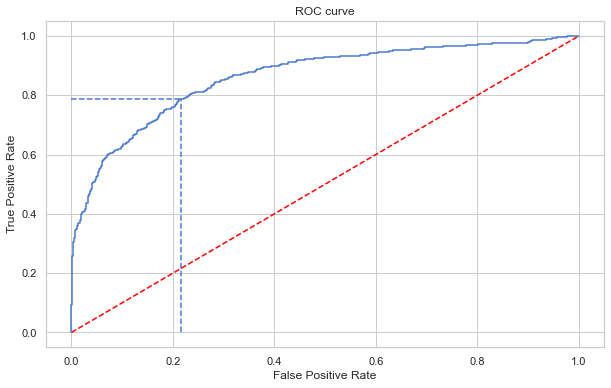

In [130]:
fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['LogisticRegression'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [ ]:
# pr, re, thres = precision_recall_curve( y_test, y_test_pred_prob)

# fig, axs = plt.subplots(figsize=(12, 6))
# plt.plot(re, pr)
# plt.xlabel('recall')
# plt.ylabel('precision')

In [131]:
#y_test_pred_prob

y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.544 = 78.6084


### DecisionTreeClassifier

In [132]:
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_leaf': [1, 3, 5, 8]
}

decisionTreeClassifier_gridsearch_hp_tuning = GridSearchCV(
        DecisionTreeClassifier(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 4
)

decisionTreeClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(decisionTreeClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", decisionTreeClassifier_gridsearch_hp_tuning.best_score_)
print('acc X_train = ', decisionTreeClassifier_gridsearch_hp_tuning.score(X_train, y_train))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'max_depth': 5, 'min_samples_leaf': 3}
best_score =  0.780416242132103
acc X_train =  0.7985332182916307


In [255]:
dt_mod = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 3).fit(X_train, y_train)
print('Acc Train =', round(dt_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(dt_mod.score(X_test, y_test) * 100, 2))

model_acc['DecisionTreeClassifier'] = (round(dt_mod.score(X_test, y_test) * 100, 2), dt_mod)

y_test_pred_prob = pd.DataFrame(dt_mod.predict_proba(X_test)[:, 1])

Acc Train = 79.85
Acc Test = 78.55


tpr = 0.8130081300813008 fpr = 0.22209567198177677 threshold = 0.5393258426966292


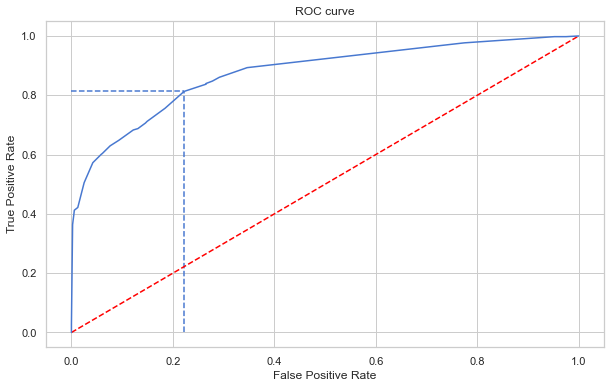

In [134]:
fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['DecisionTreeClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [144]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.539 = 78.6084


### RandomForestClassifier

In [136]:
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_leaf': [1, 3, 5, 8],
    'n_estimators': [50, 100, 150, 200, 250, 300]
}

randomForestClassifier_gridsearch_hp_tuning = GridSearchCV(
        RandomForestClassifier(),
        param_grid=param_grid,
        n_jobs=-1,
        verbose = 4
)

randomForestClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(randomForestClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", randomForestClassifier_gridsearch_hp_tuning.best_score_)
print('acc X_train = ', randomForestClassifier_gridsearch_hp_tuning.score(X_train, y_train))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 250}
best_score =  0.8012674490170625
acc X_train =  0.8809318377911993


In [256]:
rf_mod = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators = 250)
rf_mod.fit(X_train, y_train)

print('Acc Train =', round(rf_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(rf_mod.score(X_test, y_test) * 100, 2))

model_acc['RandomForestClassifier'] = (round(rf_mod.score(X_test, y_test) * 100, 2), rf_mod)

d = {'Features': X_train.columns, 'importance': rf_mod.feature_importances_*100}
features_imp_df = pd.DataFrame(data=d).sort_values('importance', ascending=False)
features_imp_df

Acc Train = 87.92
Acc Test = 80.85


Features  importance
38                 TotalSpend   13.423982
43                    NoSpend    8.889983
30                  FoodCourt    7.665911
32                        Spa    7.534157
26                  CryoSleep    7.199363
29                RoomService    7.194973
33                     VRDeck    6.907424
31               ShoppingMall    5.928310
36                   CabinNum    4.457665
34                    GroupId    4.252145
27                        Age    3.387283
0                    x0_Earth    2.278378
42                 NameLength    2.105918
1                   x0_Europa    1.859197
13                       x3_E    1.531294
19     x4_Earth - TRAPPIST-1e    1.347522
15                       x3_G    1.231052
14                       x3_F    1.170829
7                        x2_P    1.124561
8                        x2_S    1.124489
39                  GroupSize    1.011184
41     namesakes_num_in_group    0.966701
35                 NumInGroup    0.952475
2                     x0_Mars    0.678656
25      x4_Mars - TRAPPIST-1e    0.596319
37                    IsChild    0.548211
11                       x3_C    0.532934
20    x4_Europa - 55 Cancri e    0.508754
10                       x3_B    0.480592
22    x4_Europa - TRAPPIST-1e    0.450021
5              x1_TRAPPIST-1e    0.445491
40                   IsSingle    0.379511
3              x1_55 Cancri e    0.337420
4            x1_PSO J318.5-22    0.322843
18   x4_Earth - PSO J318.5-22    0.242510
17     x4_Earth - 55 Cancri e    0.213325
12                       x3_D    0.213291
9                        x3_A    0.136160
28                        VIP    0.125256
6                        x2_O    0.085157
23      x4_Mars - 55 Cancri e    0.078498
24    x4_Mars - PSO J318.5-22    0.066421
21  x4_Europa - PSO J318.5-22    0.011114
16                       x3_T    0.002720

tpr = 0.7921022067363531 fpr = 0.1662870159453303 threshold = 0.5199264252758352


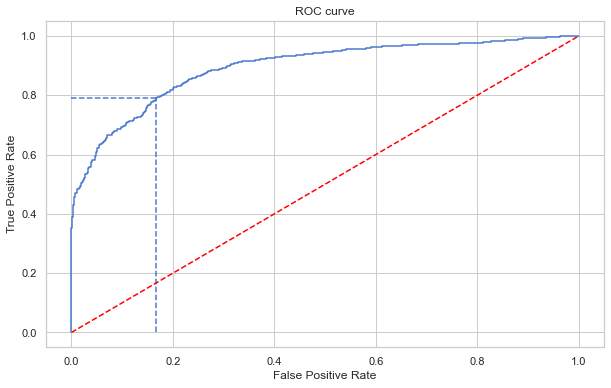

In [156]:
y_test_pred_prob = pd.DataFrame(rf_mod.predict_proba(X_test)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['RandomForestClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [157]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.52 = 81.25359


### GradientBoostingClassifier

In [158]:
# min_samples_leaf=[3, 5, 8]

param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],
    "n_estimators": [50, 100, 150, 200, 250],
    'max_depth' : [3, 5, 8],
    'min_samples_leaf' : [1, 3, 5, 8]
}


gradientBoostingClassifier_gridsearch_hp_tuning = GridSearchCV(
        GradientBoostingClassifier(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 2
)

gradientBoostingClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(gradientBoostingClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", gradientBoostingClassifier_gridsearch_hp_tuning.best_score_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 200}
best_score =  0.8065877765077657


In [266]:
gb_mod = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, min_samples_leaf=5) 

gb_mod.fit(X_train, y_train)

print('Acc Train =', round(gb_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(gb_mod.score(X_test, y_test) * 100, 2))

model_acc['GradientBoostingClassifier'] = (round(gb_mod.score(X_test, y_test) * 100, 2), gb_mod)

Acc Train = 85.1
Acc Test = 81.14


tpr = 0.8141695702671312 fpr = 0.18337129840546698 threshold = 0.5201111213823948


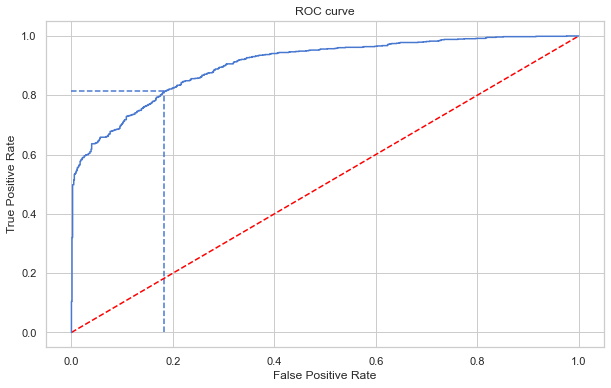

In [161]:
y_test_pred_prob = pd.DataFrame(gb_mod.predict_proba(X_test)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['GradientBoostingClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [162]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.52 = 81.48361


In [ ]:
# gb_mod_all = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, min_samples_leaf=3) 
# gb_mod_all.fit(X, y)

# print('Acc Train =', round(gb_mod_all.score(X, y) * 100, 2))

# y_pred_prob = pd.DataFrame(gb_mod_all.predict_proba(X)[:, 1])
# best_threshold = get_roc_curve (y, y_pred_prob)

### PCA

In [163]:
pca_model = PCA()
pca_model.fit(X)
pca_model.explained_variance_

array([8.01253617e-01, 7.08186507e-01, 5.50042152e-01, 4.92000550e-01,
       4.18913543e-01, 2.88391322e-01, 2.11822823e-01, 1.95599705e-01,
       1.31432563e-01, 1.21141076e-01, 1.05553843e-01, 1.01045758e-01,
       9.06879306e-02, 6.78450093e-02, 5.48487343e-02, 4.73572724e-02,
       4.51527983e-02, 4.16213982e-02, 4.07905392e-02, 3.78172956e-02,
       3.68256941e-02, 3.44146900e-02, 2.15689056e-02, 1.77277718e-02,
       1.77043695e-02, 1.63565874e-02, 1.42079741e-02, 1.26515273e-02,
       1.13545330e-02, 8.96807853e-03, 5.73974941e-03, 4.39572055e-03,
       3.51034175e-03, 6.49402908e-04, 9.42942285e-14, 2.51186384e-14,
       1.56139309e-14, 7.41888969e-15, 4.78846487e-15, 1.73407730e-15,
       1.73407730e-15, 1.73407730e-15, 1.73407730e-15, 1.17523376e-15],
      dtype=float32)

Text(0, 0.5, 'Explained Variance')

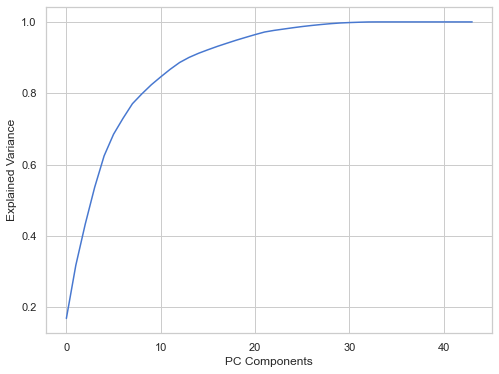

In [164]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))


plt.xlabel("PC Components")
plt.ylabel("Explained Variance")

In [165]:
pca_model_90 = PCA(n_components=2)
pca_model_90.fit(X)

X_train_auto_reduced = pca_model_90.transform(X)
X_train_auto_reduced.shape


(8693, 2)

Text(0, 0.5, 'Component 1')

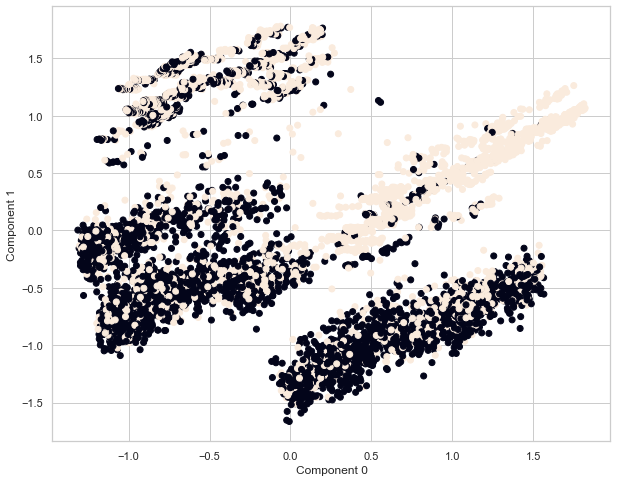

In [166]:
plt.figure(figsize=(10,8))

plt.scatter(X_train_auto_reduced[:, 0], X_train_auto_reduced[:, 1], c=y)

plt.xlabel("Component 0")
plt.ylabel("Component 1")

In [ ]:
# X_train_auto_reduced = pd.DataFrame(X_train_auto_reduced)

# X_pca = pd.concat((X, X_train_auto_reduced), axis=1)
# X_pca

In [ ]:
# pca_model_90.fit(X_test)

# X_test_auto_reduced = pca_model_90.transform(X_test)
# X_test_auto_reduced.shape

# X_test_auto_reduced = pd.DataFrame(X_test_auto_reduced)

# X_test_pca = pd.concat((X_test, X_test_auto_reduced), axis=1)
# X_test_pca

In [ ]:
# gb_with_pca_mod = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=4, min_samples_leaf=3) 
# gb_with_pca_mod.fit(X_pca, y)

# print('Acc Train =', round(gb_with_pca_mod.score(X_pca, y) * 100, 2))
# print('Acc Test =', round(gb_with_pca_mod.score(X_test_pca, y_test) * 100, 2))

### SVM

In [167]:
param_grid = {
    'C': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

SVC_gridsearch_hp_tuning = GridSearchCV(
        SVC(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 2
)

SVC_gridsearch_hp_tuning.fit(X_train, y_train)
print(SVC_gridsearch_hp_tuning.best_params_)

print("best_score = ", SVC_gridsearch_hp_tuning.best_score_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
{'C': 1.5, 'gamma': 'scale', 'kernel': 'poly'}
best_score =  0.7935010783608915


In [257]:
svc_mod = SVC(C = 1.5, gamma = 'scale', kernel = 'poly', probability = True)
svc_mod.fit(X_train, y_train)

print('Acc Train =', round(svc_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(svc_mod.score(X_test, y_test) * 100, 2))

model_acc['SVC'] = (round(svc_mod.score(X_test, y_test) * 100, 2), svc_mod)


Acc Train = 81.85
Acc Test = 79.64


tpr = 0.8385598141695703 fpr = 0.23462414578587698 threshold = 0.456507117667376


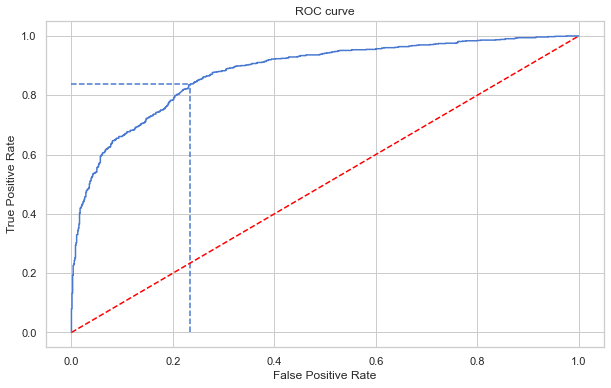

In [169]:
y_test_pred_prob = pd.DataFrame(svc_mod.predict_proba(X_test)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['SVC'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [170]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.457 = 80.10351


### KNeighborsClassifier

In [171]:
param_grid = {
    'n_neighbors': [2, 3, 5, 8, 10, 12],
    'p': [1, 2]
}

kNeighborsClassifier_gridsearch_hp_tuning = GridSearchCV(
        KNeighborsClassifier(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 2
)

kNeighborsClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(kNeighborsClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", kNeighborsClassifier_gridsearch_hp_tuning.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'n_neighbors': 12, 'p': 2}
best_score =  0.7622956415600806


In [258]:
kn_mod = KNeighborsClassifier(n_neighbors=12, p=2)
kn_mod.fit(X_train, y_train)

print('Acc Train =', round(kn_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(kn_mod.score(X_test, y_test) * 100, 2))

model_acc['KNeighborsClassifier'] = (round(kn_mod.score(X_test, y_test) * 100, 2), kn_mod)

Acc Train = 80.21
Acc Test = 76.6


tpr = 0.6968641114982579 fpr = 0.1662870159453303 threshold = 0.5833333333333334


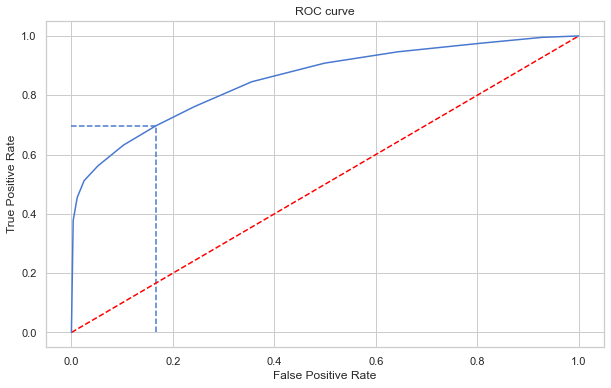

In [174]:
y_test_pred_prob = pd.DataFrame(kn_mod.predict_proba(X_test)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['KNeighborsClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [175]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.583 = 76.59574


### XGBClassifier

In [176]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],
    "n_estimators": [50, 100, 150, 200, 250],
    'max_depth' : [3, 5, 8]
}


XGBClassifier_gridsearch_hp_tuning = GridSearchCV(
        XGBClassifier(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 2
)

XGBClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(XGBClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", XGBClassifier_gridsearch_hp_tuning.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
best_score =  0.8065878799476595


In [259]:
xgb_mod = XGBClassifier(n_estimators=250, learning_rate=0.1, max_depth=3)
xgb_mod.fit(X_train, y_train)

print('Acc Train =', round(xgb_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(xgb_mod.score(X_test, y_test) * 100, 2))

model_acc['XGBClassifier'] = (round(xgb_mod.score(X_test, y_test) * 100, 2), xgb_mod)

Acc Train = 85.09
Acc Test = 80.56


tpr = 0.8176538908246226 fpr = 0.1958997722095672 threshold = 0.51270777


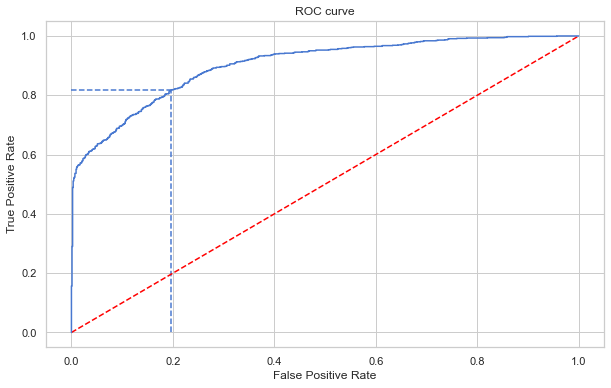

In [178]:
y_test_pred_prob = pd.DataFrame(xgb_mod.predict_proba(X_test)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['XGBClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [179]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.513 = 81.02358


In [ ]:
# xgb_mod = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
# xgb_mod.fit(X, y)

# print('Acc Train =', round(xgb_mod.score(X, y) * 100, 2))

### CatBoostClassifier

In [180]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.5],
    "n_estimators": [100, 200, 300, 400, 500],
    'max_depth' : [3, 5, 8]
}


catBoostClassifier_gridsearch_hp_tuning = GridSearchCV(
        CatBoostClassifier(),
        param_grid=param_grid,
        n_jobs=-1,
        verbose = 2
)

catBoostClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(catBoostClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", catBoostClassifier_gridsearch_hp_tuning.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
0:	learn: 0.6715886	total: 147ms	remaining: 1m 13s
1:	learn: 0.6497685	total: 152ms	remaining: 37.8s
2:	learn: 0.6313424	total: 155ms	remaining: 25.8s
3:	learn: 0.6165955	total: 159ms	remaining: 19.8s
4:	learn: 0.6047565	total: 163ms	remaining: 16.2s
5:	learn: 0.5901331	total: 167ms	remaining: 13.8s
6:	learn: 0.5783931	total: 171ms	remaining: 12s
7:	learn: 0.5692709	total: 174ms	remaining: 10.7s
8:	learn: 0.5601853	total: 178ms	remaining: 9.73s
9:	learn: 0.5516509	total: 182ms	remaining: 8.94s
10:	learn: 0.5449478	total: 186ms	remaining: 8.27s
11:	learn: 0.5387620	total: 190ms	remaining: 7.73s
12:	learn: 0.5298248	total: 194ms	remaining: 7.27s
13:	learn: 0.5250956	total: 198ms	remaining: 6.88s
14:	learn: 0.5206796	total: 202ms	remaining: 6.54s
15:	learn: 0.5134477	total: 206ms	remaining: 6.24s
16:	learn: 0.5093080	total: 210ms	remaining: 5.98s
17:	learn: 0.5049560	total: 214ms	remaining: 5.74s
18:	learn: 0.5000185	total: 219

181:	learn: 0.3658646	total: 909ms	remaining: 1.59s
182:	learn: 0.3654361	total: 913ms	remaining: 1.58s
183:	learn: 0.3651905	total: 917ms	remaining: 1.57s
184:	learn: 0.3647995	total: 922ms	remaining: 1.57s
185:	learn: 0.3644163	total: 926ms	remaining: 1.56s
186:	learn: 0.3641485	total: 930ms	remaining: 1.56s
187:	learn: 0.3639176	total: 934ms	remaining: 1.55s
188:	learn: 0.3636846	total: 939ms	remaining: 1.54s
189:	learn: 0.3632983	total: 943ms	remaining: 1.54s
190:	learn: 0.3630024	total: 947ms	remaining: 1.53s
191:	learn: 0.3628494	total: 951ms	remaining: 1.53s
192:	learn: 0.3624410	total: 956ms	remaining: 1.52s
193:	learn: 0.3620925	total: 960ms	remaining: 1.51s
194:	learn: 0.3615618	total: 964ms	remaining: 1.51s
195:	learn: 0.3613007	total: 968ms	remaining: 1.5s
196:	learn: 0.3610058	total: 972ms	remaining: 1.49s
197:	learn: 0.3606136	total: 976ms	remaining: 1.49s
198:	learn: 0.3603982	total: 980ms	remaining: 1.48s
199:	learn: 0.3601614	total: 984ms	remaining: 1.48s
200:	learn: 0

356:	learn: 0.3196475	total: 1.63s	remaining: 655ms
357:	learn: 0.3195041	total: 1.64s	remaining: 650ms
358:	learn: 0.3193346	total: 1.64s	remaining: 645ms
359:	learn: 0.3190688	total: 1.65s	remaining: 640ms
360:	learn: 0.3188957	total: 1.65s	remaining: 636ms
361:	learn: 0.3186951	total: 1.66s	remaining: 631ms
362:	learn: 0.3185346	total: 1.66s	remaining: 626ms
363:	learn: 0.3183291	total: 1.66s	remaining: 622ms
364:	learn: 0.3181640	total: 1.67s	remaining: 617ms
365:	learn: 0.3179669	total: 1.67s	remaining: 612ms
366:	learn: 0.3176881	total: 1.68s	remaining: 608ms
367:	learn: 0.3174850	total: 1.68s	remaining: 603ms
368:	learn: 0.3173196	total: 1.68s	remaining: 598ms
369:	learn: 0.3171836	total: 1.69s	remaining: 593ms
370:	learn: 0.3169669	total: 1.69s	remaining: 589ms
371:	learn: 0.3167441	total: 1.7s	remaining: 584ms
372:	learn: 0.3165412	total: 1.7s	remaining: 580ms
373:	learn: 0.3162564	total: 1.71s	remaining: 575ms
374:	learn: 0.3160403	total: 1.71s	remaining: 570ms
375:	learn: 0.

In [260]:
cbc_mod = CatBoostClassifier(n_estimators=500, learning_rate=0.05, max_depth=5)

cbc_mod.fit(X_train, y_train)

print('Acc Train =', round(cbc_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(cbc_mod.score(X_test, y_test) * 100, 2))

model_acc['CatBoostClassifier'] = (round(cbc_mod.score(X_test, y_test) * 100, 2), cbc_mod)

0:	learn: 0.6715886	total: 4.44ms	remaining: 2.22s
1:	learn: 0.6497685	total: 8.64ms	remaining: 2.15s
2:	learn: 0.6313424	total: 13.1ms	remaining: 2.16s
3:	learn: 0.6165955	total: 17.3ms	remaining: 2.15s
4:	learn: 0.6047565	total: 21.8ms	remaining: 2.16s
5:	learn: 0.5901331	total: 25.8ms	remaining: 2.13s
6:	learn: 0.5783931	total: 29.9ms	remaining: 2.11s
7:	learn: 0.5692709	total: 33.6ms	remaining: 2.07s
8:	learn: 0.5601853	total: 38ms	remaining: 2.07s
9:	learn: 0.5516509	total: 42.3ms	remaining: 2.07s
10:	learn: 0.5449478	total: 46.1ms	remaining: 2.05s
11:	learn: 0.5387620	total: 50.4ms	remaining: 2.05s
12:	learn: 0.5298248	total: 54.7ms	remaining: 2.05s
13:	learn: 0.5250956	total: 58.9ms	remaining: 2.04s
14:	learn: 0.5206796	total: 63.5ms	remaining: 2.05s
15:	learn: 0.5134477	total: 67.9ms	remaining: 2.05s
16:	learn: 0.5093080	total: 72.2ms	remaining: 2.05s
17:	learn: 0.5049560	total: 76.6ms	remaining: 2.05s
18:	learn: 0.5000185	total: 80.9ms	remaining: 2.05s
19:	learn: 0.4967157	tot

199:	learn: 0.3601614	total: 913ms	remaining: 1.37s
200:	learn: 0.3598831	total: 917ms	remaining: 1.36s
201:	learn: 0.3594937	total: 921ms	remaining: 1.36s
202:	learn: 0.3591371	total: 926ms	remaining: 1.35s
203:	learn: 0.3587662	total: 930ms	remaining: 1.35s
204:	learn: 0.3585065	total: 934ms	remaining: 1.34s
205:	learn: 0.3582238	total: 939ms	remaining: 1.34s
206:	learn: 0.3579861	total: 943ms	remaining: 1.33s
207:	learn: 0.3575965	total: 948ms	remaining: 1.33s
208:	learn: 0.3573726	total: 952ms	remaining: 1.32s
209:	learn: 0.3571523	total: 956ms	remaining: 1.32s
210:	learn: 0.3567146	total: 961ms	remaining: 1.31s
211:	learn: 0.3564900	total: 965ms	remaining: 1.31s
212:	learn: 0.3562025	total: 970ms	remaining: 1.31s
213:	learn: 0.3560374	total: 974ms	remaining: 1.3s
214:	learn: 0.3558365	total: 979ms	remaining: 1.3s
215:	learn: 0.3554548	total: 984ms	remaining: 1.29s
216:	learn: 0.3551950	total: 988ms	remaining: 1.29s
217:	learn: 0.3548987	total: 992ms	remaining: 1.28s
218:	learn: 0.

366:	learn: 0.3176881	total: 1.63s	remaining: 591ms
367:	learn: 0.3174850	total: 1.64s	remaining: 587ms
368:	learn: 0.3173196	total: 1.64s	remaining: 583ms
369:	learn: 0.3171836	total: 1.65s	remaining: 578ms
370:	learn: 0.3169669	total: 1.65s	remaining: 574ms
371:	learn: 0.3167441	total: 1.66s	remaining: 570ms
372:	learn: 0.3165412	total: 1.66s	remaining: 565ms
373:	learn: 0.3162564	total: 1.66s	remaining: 561ms
374:	learn: 0.3160403	total: 1.67s	remaining: 556ms
375:	learn: 0.3158625	total: 1.67s	remaining: 552ms
376:	learn: 0.3156029	total: 1.68s	remaining: 547ms
377:	learn: 0.3154028	total: 1.68s	remaining: 543ms
378:	learn: 0.3152610	total: 1.69s	remaining: 539ms
379:	learn: 0.3150768	total: 1.69s	remaining: 534ms
380:	learn: 0.3149100	total: 1.7s	remaining: 530ms
381:	learn: 0.3147168	total: 1.7s	remaining: 526ms
382:	learn: 0.3144597	total: 1.71s	remaining: 521ms
383:	learn: 0.3141522	total: 1.71s	remaining: 517ms
384:	learn: 0.3139195	total: 1.72s	remaining: 513ms
385:	learn: 0.

tpr = 0.8397212543554007 fpr = 0.1947608200455581 threshold = 0.4969305625069996


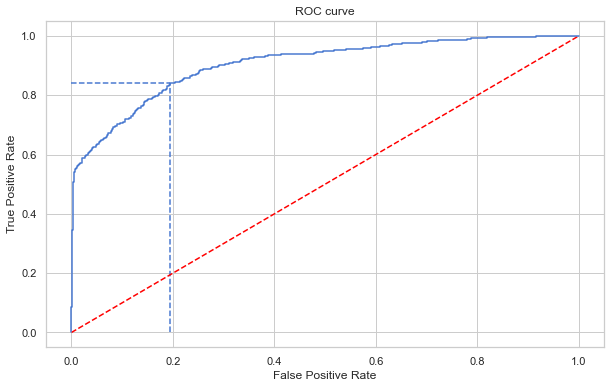

In [182]:
y_test_pred_prob = pd.DataFrame(cbc_mod.predict_proba(X_test)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['CatBoostClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [183]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.497 = 82.17366


In [184]:
cbc_mod_all = CatBoostClassifier(n_estimators=500, learning_rate=0.05, max_depth=5) #var1 BEST!!!!!

# cbc_mod_all = CatBoostClassifier(n_estimators=400, learning_rate=0.05, max_depth=5) #var1
# cbc_mod_all = CatBoostClassifier(n_estimators=100, learning_rate=0.01, max_depth=8) #var2 schlechter als var1
# {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}
cbc_mod_all.fit(X, y)

0:	learn: 0.6717601	total: 18.1ms	remaining: 9.04s
1:	learn: 0.6559285	total: 32.4ms	remaining: 8.07s
2:	learn: 0.6367266	total: 40.2ms	remaining: 6.67s
3:	learn: 0.6199487	total: 48ms	remaining: 5.95s
4:	learn: 0.6064402	total: 55.3ms	remaining: 5.47s
5:	learn: 0.5930960	total: 61.9ms	remaining: 5.1s
6:	learn: 0.5824253	total: 66.4ms	remaining: 4.68s
7:	learn: 0.5713423	total: 70.9ms	remaining: 4.36s
8:	learn: 0.5628770	total: 75.2ms	remaining: 4.1s
9:	learn: 0.5510038	total: 79.8ms	remaining: 3.91s
10:	learn: 0.5445644	total: 83.8ms	remaining: 3.73s
11:	learn: 0.5371470	total: 88.3ms	remaining: 3.59s
12:	learn: 0.5298268	total: 92.9ms	remaining: 3.48s
13:	learn: 0.5214459	total: 97.5ms	remaining: 3.38s
14:	learn: 0.5153465	total: 102ms	remaining: 3.3s
15:	learn: 0.5113514	total: 106ms	remaining: 3.22s
16:	learn: 0.5073899	total: 111ms	remaining: 3.15s
17:	learn: 0.5030747	total: 116ms	remaining: 3.09s
18:	learn: 0.4994706	total: 120ms	remaining: 3.04s
19:	learn: 0.4945849	total: 125m

187:	learn: 0.3703787	total: 905ms	remaining: 1.5s
188:	learn: 0.3700724	total: 910ms	remaining: 1.5s
189:	learn: 0.3691602	total: 915ms	remaining: 1.49s
190:	learn: 0.3689259	total: 919ms	remaining: 1.49s
191:	learn: 0.3684667	total: 924ms	remaining: 1.48s
192:	learn: 0.3682771	total: 929ms	remaining: 1.48s
193:	learn: 0.3681055	total: 933ms	remaining: 1.47s
194:	learn: 0.3678036	total: 938ms	remaining: 1.47s
195:	learn: 0.3676447	total: 943ms	remaining: 1.46s
196:	learn: 0.3674059	total: 948ms	remaining: 1.46s
197:	learn: 0.3671371	total: 953ms	remaining: 1.45s
198:	learn: 0.3668385	total: 957ms	remaining: 1.45s
199:	learn: 0.3666176	total: 962ms	remaining: 1.44s
200:	learn: 0.3664413	total: 966ms	remaining: 1.44s
201:	learn: 0.3661534	total: 971ms	remaining: 1.43s
202:	learn: 0.3658395	total: 976ms	remaining: 1.43s
203:	learn: 0.3653964	total: 980ms	remaining: 1.42s
204:	learn: 0.3652394	total: 985ms	remaining: 1.42s
205:	learn: 0.3650271	total: 989ms	remaining: 1.41s
206:	learn: 0.

351:	learn: 0.3314236	total: 1.65s	remaining: 695ms
352:	learn: 0.3312920	total: 1.66s	remaining: 690ms
353:	learn: 0.3310145	total: 1.66s	remaining: 685ms
354:	learn: 0.3307983	total: 1.67s	remaining: 681ms
355:	learn: 0.3306109	total: 1.67s	remaining: 676ms
356:	learn: 0.3303871	total: 1.68s	remaining: 671ms
357:	learn: 0.3302206	total: 1.68s	remaining: 667ms
358:	learn: 0.3300003	total: 1.69s	remaining: 662ms
359:	learn: 0.3298057	total: 1.69s	remaining: 657ms
360:	learn: 0.3296643	total: 1.7s	remaining: 653ms
361:	learn: 0.3294424	total: 1.7s	remaining: 648ms
362:	learn: 0.3292544	total: 1.7s	remaining: 643ms
363:	learn: 0.3290123	total: 1.71s	remaining: 639ms
364:	learn: 0.3287291	total: 1.71s	remaining: 634ms
365:	learn: 0.3285776	total: 1.72s	remaining: 629ms
366:	learn: 0.3284752	total: 1.72s	remaining: 624ms
367:	learn: 0.3282392	total: 1.73s	remaining: 620ms
368:	learn: 0.3280258	total: 1.73s	remaining: 615ms
369:	learn: 0.3278825	total: 1.74s	remaining: 610ms
370:	learn: 0.3

In [185]:
y_pred_prob = pd.DataFrame(cbc_mod_all.predict_proba(X)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y, y_pred_prob)

print(best_threshold)

tpr = 0.8492462311557789 fpr = 0.11077636152954809 threshold = 0.5299397069432288
0.5299397069432288


### LGBMClassifier

In [186]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],
    "n_estimators": [50, 100, 150, 200, 250],
    'max_depth' : [3, 5, 8, 12]#,
 #   'min_samples_leaf' : [1, 3, 5, 8]
}


LGBMClassifier_gridsearch_hp_tuning = GridSearchCV(
        LGBMClassifier(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 2
)

LGBMClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(LGBMClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", LGBMClassifier_gridsearch_hp_tuning.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 150}
best_score =  0.8097503478166423


In [261]:
lgbmc_mod= LGBMClassifier(learning_rate = 0.05, max_depth = 12, n_estimators = 150)
lgbmc_mod.fit(X_train, y_train)

print('Acc Train =', round(lgbmc_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(lgbmc_mod.score(X_test, y_test) * 100, 2))

model_acc['LGBMClassifier'] = (round(lgbmc_mod.score(X_test, y_test) * 100, 2), lgbmc_mod)

Acc Train = 88.84
Acc Test = 81.08


tpr = 0.8397212543554007 fpr = 0.1947608200455581 threshold = 0.4969305625069996


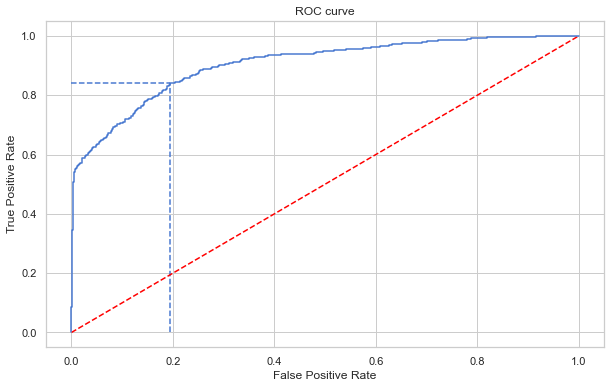

In [188]:
y_test_pred_prob = pd.DataFrame(cbc_mod.predict_proba(X_test)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['LGBMClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [189]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.497 = 82.17366


In [190]:
lgbmc_mod_all = CatBoostClassifier(n_estimators=100, learning_rate=0.05, max_depth=12) #var1
#{'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 100}

lgbmc_mod_all.fit(X, y)

0:	learn: 0.6673417	total: 115ms	remaining: 11.4s
1:	learn: 0.6388096	total: 246ms	remaining: 12s
2:	learn: 0.6120298	total: 378ms	remaining: 12.2s
3:	learn: 0.5885028	total: 496ms	remaining: 11.9s
4:	learn: 0.5665156	total: 616ms	remaining: 11.7s
5:	learn: 0.5489143	total: 754ms	remaining: 11.8s
6:	learn: 0.5321396	total: 886ms	remaining: 11.8s
7:	learn: 0.5165535	total: 1.02s	remaining: 11.7s
8:	learn: 0.5066006	total: 1.15s	remaining: 11.6s
9:	learn: 0.4955892	total: 1.29s	remaining: 11.6s
10:	learn: 0.4854435	total: 1.41s	remaining: 11.4s
11:	learn: 0.4754368	total: 1.53s	remaining: 11.2s
12:	learn: 0.4654695	total: 1.65s	remaining: 11s
13:	learn: 0.4566338	total: 1.79s	remaining: 11s
14:	learn: 0.4508601	total: 1.92s	remaining: 10.9s
15:	learn: 0.4448802	total: 2.05s	remaining: 10.8s
16:	learn: 0.4381789	total: 2.19s	remaining: 10.7s
17:	learn: 0.4326503	total: 2.32s	remaining: 10.6s
18:	learn: 0.4285685	total: 2.44s	remaining: 10.4s
19:	learn: 0.4232935	total: 2.56s	remaining: 10

### ROC PLOT

In [267]:
for m in model_acc.keys():
    print(m, model_acc[m][0])

LogisticRegression 78.32
DecisionTreeClassifier 78.55
RandomForestClassifier 80.85
GradientBoostingClassifier 81.14
SVC 79.64
KNeighborsClassifier 76.6
XGBClassifier 80.56
CatBoostClassifier 82.17
LGBMClassifier 81.08


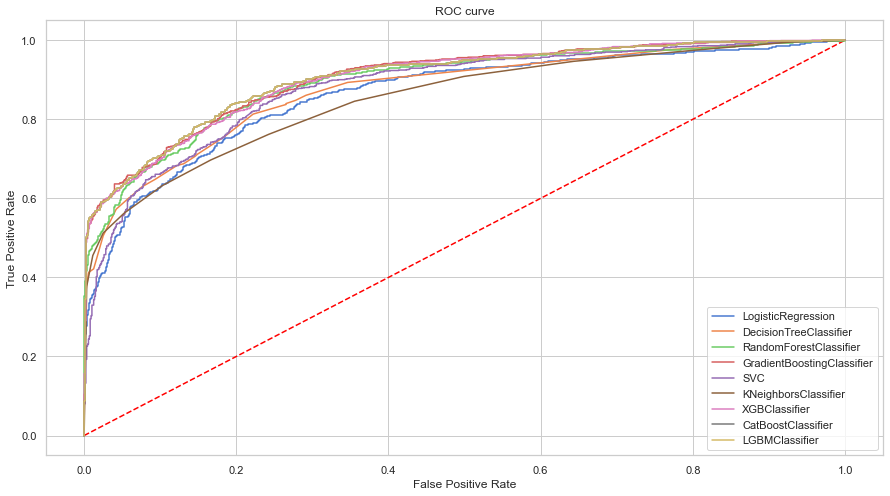

In [192]:
fig, axs = plt.subplots(figsize=(15, 8))
colors= []

plt.plot([0, 1], [0, 1], linestyle='dashed', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

for model in roc_curves.keys():
    plt.plot(roc_curves[model][0], roc_curves[model][1], label=model)
    axs.legend()



In [193]:
roc_curves['DecisionTreeClassifier'][0]

array([0.        , 0.        , 0.0022779 , 0.00341686, 0.00455581,
       0.00569476, 0.01252847, 0.02505695, 0.04214123, 0.05922551,
       0.06036446, 0.07630979, 0.09339408, 0.12186788, 0.1309795 ,
       0.14578588, 0.14920273, 0.18451025, 0.22209567, 0.26537585,
       0.26537585, 0.27790433, 0.29157175, 0.3405467 , 0.34624146,
       0.72665148, 0.77448747, 0.95216401, 0.97494305, 1.        ])

### Modell-Ensemble

In [198]:
# LGBMClassifier                81.08
# GradientBoostingClassifier    81.14
# CatBoostClassifier            82.17


# xgb_mod = XGBClassifier(n_estimators=250, learning_rate=0.1, max_depth=3)
# xgb_mod.fit(X_train, y_train)

y_test_pred_gb_mod = gb_mod.predict_proba(X_test)[:, 1]
y_test_pred_cbc_mod = cbc_mod.predict_proba(X_test)[:, 1]
y_test_pred_lgbmc_mod = lgbmc_mod.predict_proba(X_test)[:, 1]

y_test_pred_prob = pd.DataFrame((y_test_pred_gb_mod + y_test_pred_cbc_mod + y_test_pred_lgbmc_mod) / 3)


fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

tpr = 0.8315911730545877 fpr = 0.19248291571753987 threshold = 0.5081899358189764
ACC with threshold 0.508 = 81.88614


0:	learn: 0.6717601	total: 11.8ms	remaining: 5.91s
1:	learn: 0.6559285	total: 20.4ms	remaining: 5.07s
2:	learn: 0.6367266	total: 25.1ms	remaining: 4.16s
3:	learn: 0.6199487	total: 29.5ms	remaining: 3.66s
4:	learn: 0.6064402	total: 33.7ms	remaining: 3.33s
5:	learn: 0.5930960	total: 38.3ms	remaining: 3.15s
6:	learn: 0.5824253	total: 42.8ms	remaining: 3.02s
7:	learn: 0.5713423	total: 47.4ms	remaining: 2.92s
8:	learn: 0.5628770	total: 51.9ms	remaining: 2.83s
9:	learn: 0.5510038	total: 56.5ms	remaining: 2.77s
10:	learn: 0.5445644	total: 60.6ms	remaining: 2.69s
11:	learn: 0.5371470	total: 65.1ms	remaining: 2.65s
12:	learn: 0.5298268	total: 69.7ms	remaining: 2.61s
13:	learn: 0.5214459	total: 74.3ms	remaining: 2.58s
14:	learn: 0.5153465	total: 78.8ms	remaining: 2.55s
15:	learn: 0.5113514	total: 83.4ms	remaining: 2.52s
16:	learn: 0.5073899	total: 87.9ms	remaining: 2.5s
17:	learn: 0.5030747	total: 92.5ms	remaining: 2.48s
18:	learn: 0.4994706	total: 97ms	remaining: 2.46s
19:	learn: 0.4945849	tota

194:	learn: 0.3678036	total: 928ms	remaining: 1.45s
195:	learn: 0.3676447	total: 933ms	remaining: 1.45s
196:	learn: 0.3674059	total: 937ms	remaining: 1.44s
197:	learn: 0.3671371	total: 942ms	remaining: 1.44s
198:	learn: 0.3668385	total: 947ms	remaining: 1.43s
199:	learn: 0.3666176	total: 952ms	remaining: 1.43s
200:	learn: 0.3664413	total: 956ms	remaining: 1.42s
201:	learn: 0.3661534	total: 961ms	remaining: 1.42s
202:	learn: 0.3658395	total: 965ms	remaining: 1.41s
203:	learn: 0.3653964	total: 970ms	remaining: 1.41s
204:	learn: 0.3652394	total: 975ms	remaining: 1.4s
205:	learn: 0.3650271	total: 980ms	remaining: 1.4s
206:	learn: 0.3648086	total: 984ms	remaining: 1.39s
207:	learn: 0.3645508	total: 989ms	remaining: 1.39s
208:	learn: 0.3642864	total: 993ms	remaining: 1.38s
209:	learn: 0.3639472	total: 998ms	remaining: 1.38s
210:	learn: 0.3635741	total: 1s	remaining: 1.37s
211:	learn: 0.3631929	total: 1.01s	remaining: 1.37s
212:	learn: 0.3627399	total: 1.01s	remaining: 1.36s
213:	learn: 0.362

361:	learn: 0.3294424	total: 1.69s	remaining: 644ms
362:	learn: 0.3292544	total: 1.69s	remaining: 639ms
363:	learn: 0.3290123	total: 1.7s	remaining: 635ms
364:	learn: 0.3287291	total: 1.7s	remaining: 630ms
365:	learn: 0.3285776	total: 1.71s	remaining: 625ms
366:	learn: 0.3284752	total: 1.71s	remaining: 621ms
367:	learn: 0.3282392	total: 1.72s	remaining: 616ms
368:	learn: 0.3280258	total: 1.72s	remaining: 611ms
369:	learn: 0.3278825	total: 1.73s	remaining: 607ms
370:	learn: 0.3276901	total: 1.73s	remaining: 602ms
371:	learn: 0.3275092	total: 1.74s	remaining: 598ms
372:	learn: 0.3273203	total: 1.74s	remaining: 593ms
373:	learn: 0.3271396	total: 1.75s	remaining: 588ms
374:	learn: 0.3269237	total: 1.75s	remaining: 583ms
375:	learn: 0.3267089	total: 1.75s	remaining: 579ms
376:	learn: 0.3265159	total: 1.76s	remaining: 574ms
377:	learn: 0.3263222	total: 1.76s	remaining: 569ms
378:	learn: 0.3261838	total: 1.77s	remaining: 565ms
379:	learn: 0.3260458	total: 1.77s	remaining: 560ms
380:	learn: 0.

TypeError: fit() missing 1 required positional argument: 'y'

## Final Forcast

In [200]:
validation_df = pd.read_csv("test.csv", sep=',', engine='python')
validation_df

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
4272     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth     False       NaN    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars      True   D/296/P    55 Cancri e   NaN  False   
4275     9273_01     Europa     False   D/297/P            NaN   NaN  False   
4276     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0             0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1             0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2             0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3             0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4            10.0        0.0         635.0     0.0     0.0   Brence Harperez  
...           ...        ...           ...     ...     ...               ...  
4272          0.0        0.0           0.0     0.0     0.0       Jeron Peter  
4273          0.0      847.0          17.0    10.0   144.0     Matty Scheron  
4274          0.0        0.0           0.0     0.0     0.0       Jayrin Pore  
4275          0.0     2680.0           0.0     0.0   523.0    Kitakan Conale  
4276          0.0        0.0           0.0     0.0     0.0  Lilace Leonzaley  

[4277 rows x 13 columns]

In [201]:
passengerId_df = validation_df.loc[:, ['PassengerId']]

validation_df, am, em = data_transform(validation_df, for_visual_df, age_medians_all, expenses_means_all)

validation_df = encode_data(validation_df, nominal_encoder_all, scaler_all)

validation_df = memory_optimiz(validation_df)

validation_df

------ HomePlanet_update ------------
HomePlanet NULLs: 87
1. (after replacement through the GroupId) HomePlanet NULLs: 87
2. (after replacement through the Deck) HomePlanet NULLs: 51
3. (after replacement through the LastName) HomePlanet NULLs: 9
4. (after replacement through the Destination): 0
5. (after replacement by the most common value) HomePlanet NULLs: 0
------ Destination_update ------------
Destination NULLs: 92
(after replacement by the most common value) Destination NULLs: 0
------ LastName_update ------------
LastName NULLs: 94
(3012, 2)
(after update) LastName NULLs: 51
namesakes_num_in_group NULLs: 51
namesakes_num_in_group NULLs: 0
------ CabinDeck_update ------------
CabinDeck NULLs: 100
(after update throw GroupId) CabinDeck NULLs: 63
(after update throw HomePlanet) CabinDeck NULLs: 0
------ CabinNum_update ------------
CabinNum NULLs: 100
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
A (1, 1)
B (11, 1)
C (6, 1)
D (1, 1)
E (2, 1)
F (25, 1)
G (54, 1)
CabinNum NULLs: 0
----

x0_Earth  x0_Europa  x0_Mars  x1_55 Cancri e  x1_PSO J318.5-22  \
0          1.0        0.0      0.0             0.0               0.0   
1          1.0        0.0      0.0             0.0               0.0   
2          0.0        1.0      0.0             1.0               0.0   
3          0.0        1.0      0.0             0.0               0.0   
4          1.0        0.0      0.0             0.0               0.0   
...        ...        ...      ...             ...               ...   
4272       1.0        0.0      0.0             0.0               0.0   
4273       1.0        0.0      0.0             0.0               0.0   
4274       0.0        0.0      1.0             1.0               0.0   
4275       0.0        1.0      0.0             0.0               0.0   
4276       1.0        0.0      0.0             0.0               1.0   

      x1_TRAPPIST-1e  x2_O  x2_P  x2_S  x3_A  ...   GroupId  NumInGroup  \
0                1.0   0.0   0.0   1.0   0.0  ...  0.001293    0.000000   
1                1.0   0.0   0.0   1.0   0.0  ...  0.001832    0.000000   
2                0.0   0.0   0.0   1.0   0.0  ...  0.001940    0.000000   
3                1.0   0.0   0.0   1.0   0.0  ...  0.002155    0.000000   
4                1.0   0.0   0.0   1.0   0.0  ...  0.002371    0.000000   
...              ...   ...   ...   ...   ...  ...       ...         ...   
4272             1.0   0.0   0.0   1.0   0.0  ...  0.998491    0.142857   
4273             1.0   1.0   0.0   0.0   0.0  ...  0.998815    0.000000   
4274             0.0   0.0   1.0   0.0   0.0  ...  0.999030    0.000000   
4275             1.0   0.0   1.0   0.0   0.0  ...  0.999246    0.000000   
4276             0.0   0.0   0.0   1.0   0.0  ...  0.999677    0.000000   

      CabinNum  IsChild  TotalSpend  GroupSize  IsSingle  \
0     0.003082      0.0    0.000000   0.000000       1.0   
1     0.003610      0.0    0.258001   0.000000       1.0   
2     0.001501      0.0    0.000000   0.000000       1.0   
3     0.002028      0.0    0.513060   0.000000       1.0   
4     0.004137      0.0    0.222872   0.000000       1.0   
...        ...      ...         ...        ...       ...   
4272  0.790178      0.0    0.000000   0.142857       0.0   
4273  0.793238      0.0    0.428165   0.000000       1.0   
4274  0.157549      0.0    0.000000   0.000000       1.0   
4275  0.158076      0.0    0.356356   0.000000       1.0   
4276  0.791232      0.0    0.000000   0.000000       1.0   

      namesakes_num_in_group  NameLength  NoSpend  
0                   0.000000    0.833333      1.0  
1                   0.000000    0.777778      0.0  
2                   0.000000    0.833333      1.0  
3                   0.000000    0.888889      0.0  
4                   0.000000    0.833333      0.0  
...                      ...         ...      ...  
4272                0.142857    0.611111      1.0  
4273                0.000000    0.722222      0.0  
4274                0.000000    0.611111      1.0  
4275                0.000000    0.777778      0.0  
4276                0.000000    0.888889      1.0  

[4277 rows x 44 columns]

In [241]:
gb_mod_all = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, min_samples_leaf=5) 
gb_mod_all.fit(X, y)

cbc_mod_all = CatBoostClassifier(n_estimators=500, learning_rate=0.05, max_depth=5)
cbc_mod_all.fit(X, y)

rf_mod_all = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators = 250)
rf_mod_all.fit(X, y)

lgbmc_mod_all= LGBMClassifier(learning_rate = 0.05, max_depth = 12, n_estimators = 150)
lgbmc_mod_all.fit(X, y)

xgb_mod_all = XGBClassifier(n_estimators=250, learning_rate=0.1, max_depth=3)
xgb_mod_all.fit(X, y)



y_val_pred_gb_mod = gb_mod_all.predict_proba(validation_df)[:, 1]
y_val_pred_cbc_mod = cbc_mod_all.predict_proba(validation_df)[:, 1]
y_val_pred_lgbmc_mod = lgbmc_mod_all.predict_proba(validation_df)[:, 1]
y_val_pred_rf_mod = rf_mod_all.predict_proba(validation_df)[:, 1]
y_val_pred_xgb_mod = xgb_mod_all.predict_proba(validation_df)[:, 1]

y_val_pred_prob = pd.DataFrame((y_val_pred_gb_mod + y_val_pred_cbc_mod + y_val_pred_lgbmc_mod
                               + y_val_pred_rf_mod + y_val_pred_xgb_mod) / 5)

0:	learn: 0.6717601	total: 22.6ms	remaining: 11.3s
1:	learn: 0.6559285	total: 32ms	remaining: 7.97s
2:	learn: 0.6367266	total: 41.4ms	remaining: 6.85s
3:	learn: 0.6199487	total: 50.8ms	remaining: 6.29s
4:	learn: 0.6064402	total: 59ms	remaining: 5.84s
5:	learn: 0.5930960	total: 63.5ms	remaining: 5.22s
6:	learn: 0.5824253	total: 67.8ms	remaining: 4.78s
7:	learn: 0.5713423	total: 72.5ms	remaining: 4.46s
8:	learn: 0.5628770	total: 77ms	remaining: 4.2s
9:	learn: 0.5510038	total: 81.5ms	remaining: 3.99s
10:	learn: 0.5445644	total: 85.4ms	remaining: 3.8s
11:	learn: 0.5371470	total: 90ms	remaining: 3.66s
12:	learn: 0.5298268	total: 94.5ms	remaining: 3.54s
13:	learn: 0.5214459	total: 99.2ms	remaining: 3.44s
14:	learn: 0.5153465	total: 104ms	remaining: 3.35s
15:	learn: 0.5113514	total: 108ms	remaining: 3.27s
16:	learn: 0.5073899	total: 113ms	remaining: 3.21s
17:	learn: 0.5030747	total: 117ms	remaining: 3.14s
18:	learn: 0.4994706	total: 122ms	remaining: 3.08s
19:	learn: 0.4945849	total: 126ms	rem

196:	learn: 0.3674059	total: 951ms	remaining: 1.46s
197:	learn: 0.3671371	total: 956ms	remaining: 1.46s
198:	learn: 0.3668385	total: 961ms	remaining: 1.45s
199:	learn: 0.3666176	total: 965ms	remaining: 1.45s
200:	learn: 0.3664413	total: 970ms	remaining: 1.44s
201:	learn: 0.3661534	total: 975ms	remaining: 1.44s
202:	learn: 0.3658395	total: 980ms	remaining: 1.43s
203:	learn: 0.3653964	total: 984ms	remaining: 1.43s
204:	learn: 0.3652394	total: 989ms	remaining: 1.42s
205:	learn: 0.3650271	total: 994ms	remaining: 1.42s
206:	learn: 0.3648086	total: 998ms	remaining: 1.41s
207:	learn: 0.3645508	total: 1s	remaining: 1.41s
208:	learn: 0.3642864	total: 1.01s	remaining: 1.4s
209:	learn: 0.3639472	total: 1.01s	remaining: 1.4s
210:	learn: 0.3635741	total: 1.02s	remaining: 1.39s
211:	learn: 0.3631929	total: 1.02s	remaining: 1.39s
212:	learn: 0.3627399	total: 1.03s	remaining: 1.38s
213:	learn: 0.3624739	total: 1.03s	remaining: 1.38s
214:	learn: 0.3622297	total: 1.03s	remaining: 1.37s
215:	learn: 0.362

359:	learn: 0.3298057	total: 1.7s	remaining: 660ms
360:	learn: 0.3296643	total: 1.7s	remaining: 655ms
361:	learn: 0.3294424	total: 1.71s	remaining: 650ms
362:	learn: 0.3292544	total: 1.71s	remaining: 645ms
363:	learn: 0.3290123	total: 1.71s	remaining: 641ms
364:	learn: 0.3287291	total: 1.72s	remaining: 636ms
365:	learn: 0.3285776	total: 1.72s	remaining: 631ms
366:	learn: 0.3284752	total: 1.73s	remaining: 627ms
367:	learn: 0.3282392	total: 1.73s	remaining: 622ms
368:	learn: 0.3280258	total: 1.74s	remaining: 617ms
369:	learn: 0.3278825	total: 1.74s	remaining: 612ms
370:	learn: 0.3276901	total: 1.75s	remaining: 608ms
371:	learn: 0.3275092	total: 1.75s	remaining: 603ms
372:	learn: 0.3273203	total: 1.76s	remaining: 598ms
373:	learn: 0.3271396	total: 1.76s	remaining: 593ms
374:	learn: 0.3269237	total: 1.76s	remaining: 589ms
375:	learn: 0.3267089	total: 1.77s	remaining: 584ms
376:	learn: 0.3265159	total: 1.77s	remaining: 579ms
377:	learn: 0.3263222	total: 1.78s	remaining: 574ms
378:	learn: 0.

In [238]:
# ------------------ y_val_pred_prob = pd.DataFrame(cbc_mod_all.predict_proba(validation_df)[:, 1])

#  y_val_pred = lgbmc_mod_all.predict(validation_df_pca)

# y_val_pred = lgbmc_mod_all.predict(validation_df)


#########y_val_pred = y_val_pred_prob.applymap(lambda x: x > 0.47419098173462404)

# y_val_pred = y_val_pred.astype(bool)
# y_val_pred

Text(0.5, 0, 'Predicted Propabilities')

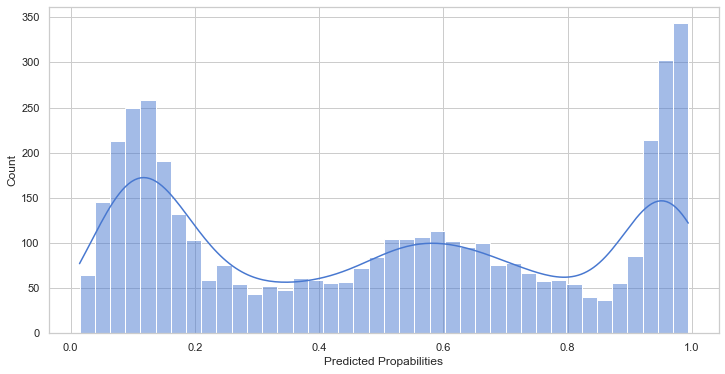

In [243]:
fig, axs = plt.subplots(figsize=(12, 6))
sns.histplot( x=y_val_pred_prob.loc[:, 0], bins=40, kde=True)

plt.xlabel('Predicted Propabilities')

In [250]:
# der Prozentsatz der transportierten Passagiere im ursprünglichen Datensatz
transported_prc = y.value_counts(normalize=True)[1]
print('Transported % = ', transported_prc)

thresholds = np.linspace(0, 0.95, num=200, endpoint=False)

res = {}

for t in thresholds:
    
    tmp_y_val_pred = y_val_pred_prob.applymap(lambda x: x > t)
    res[t] = abs(tmp_y_val_pred.value_counts(normalize=True)[True] - transported_prc)
    
    
best_threshold = min(res, key=res.get)    
print('best_threshold =', best_threshold)

Transported % =  0.5036236051995858
best_threshold = 0.5177499999999999


In [251]:
y_val_pred = y_val_pred_prob.applymap(lambda x: x > best_threshold)


In [252]:
passengerId_df['Transported'] = y_val_pred
passengerId_df

PassengerId  Transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]

In [253]:
passengerId_df.to_csv('sample_submission.csv', index=False)